# Amazon Apparel Recommendation

In [28]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

## Data downloaded from Amazon Product Advertising API

In [2]:
data = pd.read_json('tops_fashion.json')

In [3]:
data.head()

sku        asin product_type_name formatted_price author  \
0  None  B016I2TS4W             SHIRT            None   None   
1  None  B01N49AI08             SHIRT            None   None   
2  None  B01JDPCOHO             SHIRT            None   None   
3  None  B01N19U5H5             SHIRT            None   None   
4  None  B004GSI2OS             SHIRT          $26.26   None   

               color         brand publisher  \
0               None         FNC7C      None   
1               None  FIG Clothing      None   
2               None  FIG Clothing      None   
3               None       Focal18      None   
4  Onyx Black/ Stone   FeatherLite      None   

                          availability  \
0                                 None   
1                                 None   
2                                 None   
3                                 None   
4  Usually ships in 6-10 business days   

                                             reviews  \
0  [False, https://www.amazon.com/reviews/iframe?...   
1  [False, https://www.amazon.com/reviews/iframe?...   
2  [False, https://www.amazon.com/reviews/iframe?...   
3  [True, https://www.amazon.com/reviews/iframe?a...   
4  [False, https://www.amazon.com/reviews/iframe?...   

                                     large_image_url availability_type  \
0  https://images-na.ssl-images-amazon.com/images...              None   
1  https://images-na.ssl-images-amazon.com/images...              None   
2  https://images-na.ssl-images-amazon.com/images...              None   
3  https://images-na.ssl-images-amazon.com/images...              None   
4  https://images-na.ssl-images-amazon.com/images...               now   

                                     small_image_url  \
0  https://images-na.ssl-images-amazon.com/images...   
1  https://images-na.ssl-images-amazon.com/images...   
2  https://images-na.ssl-images-amazon.com/images...   
3  https://images-na.ssl-images-amazon.com/images...   
4  https://images-na.ssl-images-amazon.com/images...   

                                    editorial_review  \
0  Minions Como Superheroes Ironman Women's O Nec...   
1  Sizing runs on the small side. FIG® recommends...   
2  Sizing runs on the small side. FIG® recommends...   
3  100% Brand New & Fashion<br> Quantity: 1 Piece...   
4                                                      

                                               title model  \
0  Minions Como Superheroes Ironman Long Sleeve R...  None   
1                      FIG Clothing Womens Izo Tunic  None   
2                        FIG Clothing Womens Won Top  None   
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...  None   
4  Featherlite Ladies' Long Sleeve Stain Resistan...  None   

                                    medium_image_url manufacturer  \
0  https://images-na.ssl-images-amazon.com/images...         None   
1  https://images-na.ssl-images-amazon.com/images...         None   
2  https://images-na.ssl-images-amazon.com/images...         None   
3  https://images-na.ssl-images-amazon.com/images...         None   
4  https://images-na.ssl-images-amazon.com/images...         None   

  editorial_reivew  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

In [4]:
data.shape

(183138, 19)

In [5]:
data.columns

Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')

In [6]:
data = data[['asin','brand','color','medium_image_url','product_type_name','title','formatted_price']]

In [7]:
data.shape

(183138, 7)

In [8]:
data.head()

asin         brand              color  \
0  B016I2TS4W         FNC7C               None   
1  B01N49AI08  FIG Clothing               None   
2  B01JDPCOHO  FIG Clothing               None   
3  B01N19U5H5       Focal18               None   
4  B004GSI2OS   FeatherLite  Onyx Black/ Stone   

                                    medium_image_url product_type_name  \
0  https://images-na.ssl-images-amazon.com/images...             SHIRT   
1  https://images-na.ssl-images-amazon.com/images...             SHIRT   
2  https://images-na.ssl-images-amazon.com/images...             SHIRT   
3  https://images-na.ssl-images-amazon.com/images...             SHIRT   
4  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                               title formatted_price  
0  Minions Como Superheroes Ironman Long Sleeve R...            None  
1                      FIG Clothing Womens Izo Tunic            None  
2                        FIG Clothing Womens Won Top            None  
3  Focal18 Sailor Collar Bubble Sleeve Blouse Shi...            None  
4  Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26

In [9]:
data['product_type_name'].describe()

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object

In [10]:
data['product_type_name'].unique()

array(['SHIRT', 'SWEATER', 'APPAREL', 'OUTDOOR_RECREATION_PRODUCT',
       'BOOKS_1973_AND_LATER', 'PANTS', 'HAT', 'SPORTING_GOODS', 'DRESS',
       'UNDERWEAR', 'SKIRT', 'OUTERWEAR', 'BRA', 'ACCESSORY',
       'ART_SUPPLIES', 'SLEEPWEAR', 'ORCA_SHIRT', 'HANDBAG',
       'PET_SUPPLIES', 'SHOES', 'KITCHEN', 'ADULT_COSTUME',
       'HOME_BED_AND_BATH', 'MISC_OTHER', 'BLAZER',
       'HEALTH_PERSONAL_CARE', 'TOYS_AND_GAMES', 'SWIMWEAR',
       'CONSUMER_ELECTRONICS', 'SHORTS', 'HOME', 'AUTO_PART',
       'OFFICE_PRODUCTS', 'ETHNIC_WEAR', 'BEAUTY',
       'INSTRUMENT_PARTS_AND_ACCESSORIES', 'POWERSPORTS_PROTECTIVE_GEAR',
       'SHIRTS', 'ABIS_APPAREL', 'AUTO_ACCESSORY', 'NONAPPARELMISC',
       'TOOLS', 'BABY_PRODUCT', 'SOCKSHOSIERY',
       'POWERSPORTS_RIDING_SHIRT', 'EYEWEAR', 'SUIT', 'OUTDOOR_LIVING',
       'POWERSPORTS_RIDING_JACKET', 'HARDWARE', 'SAFETY_SUPPLY',
       'ABIS_DVD', 'VIDEO_DVD', 'GOLF_CLUB', 'MUSIC_POPULAR_VINYL',
       'HOME_FURNITURE_AND_DECOR', 'TABLET_COMPUTER',

In [11]:
product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

In [12]:
data['brand'].describe()

count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object

In [13]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

In [14]:
data['color'].describe()

count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object

In [15]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

In [16]:
data['formatted_price'].describe()

count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object

In [17]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

In [18]:
data['title'].describe()

count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object

In [19]:
data.to_pickle('pickels/180k_apparel_data')

In [20]:
data = data.loc[~data['formatted_price'].isnull()]

In [21]:
data.shape

(28395, 7)

In [22]:
data.to_pickle('pickels/28k_apparel_data')

In [23]:
# from PIL import Image
# import requests
# from io import BytesIO

In [24]:
# for index, row in images.iterrows():
#     url = row['large_image_url']
#     response = requests.get(url)
#     img = Image.open(BytesIO(response.content))
#     img.save('images/28k_images/'+row['asin']+'.jpeg')

In [25]:
data = pd.read_pickle('pickels/28k_apparel_data')

## Found some duplicate titles
- e.g 1. Womens red strip top XL and 2. Womens red strip top L
- Both of them just differ by sizes and we don't want to recommend these

In [26]:
sum(data.duplicated('title'))

2326

In [27]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
21  B014ICEDNA                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
21  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   Featherlite Ladies' Long Sleeve Stain Resistan...          $26.26  
6   Women's Unique 100% Cotton T - Special Olympic...           $9.99  
11             Ladies Cotton Tank 2x1 Ribbed Tank Top          $11.99  
15  FeatherLite Ladies' Moisture Free Mesh Sport S...          $20.54  
21  Supernatural Chibis Sam Dean And Castiel Short...           $7.50

In [28]:
data_sorted = data[data['title'].apply(lambda x:len(x.split())>4)]

In [29]:
data_sorted.shape

(27958, 7)

In [30]:
data_sorted.sort_values('title',inplace=True,ascending=False)
data_sorted.head()

C:\Users\Pranav Chougule\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


asin     brand        color  \
61973   B06Y1KZ2WB    Éclair   Black/Pink   
133820  B010RV33VE  xiaoming         Pink   
81461   B01DDSDLNS  xiaoming        White   
75995   B00X5LYO9Y  xiaoming  Red Anchors   
151570  B00WPJG35K  xiaoming        White   

                                         medium_image_url product_type_name  \
61973   https://images-na.ssl-images-amazon.com/images...             SHIRT   
133820  https://images-na.ssl-images-amazon.com/images...             SHIRT   
81461   https://images-na.ssl-images-amazon.com/images...             SHIRT   
75995   https://images-na.ssl-images-amazon.com/images...             SHIRT   
151570  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                    title formatted_price  
61973   Éclair Women's Printed Thin Strap Blouse Black...          $24.99  
133820  xiaoming Womens Sleeveless Loose Long T-shirts...          $18.19  
81461   xiaoming Women's White Long Sleeve Single Brea...          $21.58  
75995   xiaoming Stripes Tank Patch/Bear Sleeve Anchor...          $15.91  
151570  xiaoming Sleeve Sheer Loose Tassel Kimono Woma...          $14.32

In [31]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [32]:
# Iterating over data and checking if the sentance is similar with 2-3 words 
# Algorithm TC - O(n^2)
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    a = data['title'].loc[indices[i]].split()

    j = i+1
    while j < num_data_points:

        b = data['title'].loc[indices[j]].split()

        length = max(len(a), len(b))

        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

      
        if (length - count) > 2: # number of words in which both sensences differ
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [33]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

In [34]:
data.shape

(17597, 7)

In [35]:
data.to_pickle('pickels/17k_apperal_data')

In [36]:
data = pd.read_pickle('pickels/17k_apperal_data')

In [37]:
# De-deuplicating the sentances having the similar words
# e.g Womens top with red strip and Ladies top with red strip - Both of them are considered as same products
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    a = data['title'].loc[i].split()
    for j in indices:
        
        b = data['title'].loc[j].split()
        
        length = max(len(a),len(b))
        
        count  = 0

        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        if (length - count) < 3:
            indices.remove(j)

In [38]:
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [40]:
print("Number of data points after stage two of dedupe: ",data.shape[0])

Number of data points after stage two of dedupe:  16439


In [41]:
data.to_pickle('pickels/16k_apperal_data')

In [3]:
data = pd.read_pickle('pickels/16k_apperal_data')

In [11]:
import nltk
from nltk.corpus import stopwords
import math
import time
import re
import os

# Text Pre-processing

In [8]:
stop_words = set(stopwords.words('english'))
print('list of stop words: ',stop_words)

list of stop words:  {'above', 'he', 'they', 'out', 'further', 'an', 'then', 'with', 'not', 'it', 'isn', 'won', 'am', 'haven', 'about', 'to', 'because', 'is', 're', 'after', 'hers', "that'll", 'down', 'own', 'your', 'during', 't', 'd', 'very', 'against', "hasn't", 'before', 'our', 'my', 'this', 'can', 'who', 'him', "isn't", 'yours', "wasn't", 'theirs', "weren't", 'so', 'while', 'didn', 'between', 'just', 'couldn', 'have', 'ain', 'until', 'her', "won't", 'mightn', "she's", 'into', 'me', 'other', 've', "you'll", 'doing', 'them', "haven't", 'here', 'their', 'whom', "wouldn't", 'do', 'up', 'below', 'again', 'should', "hadn't", 'hasn', 'through', 'that', "should've", 'how', "aren't", "needn't", 'same', 'from', 'don', 'why', 'when', 'did', 'some', "couldn't", 'o', 'too', 'being', 'but', 'for', "shouldn't", 'yourselves', 'such', 'over', 'what', 'at', 'on', 'had', 'ourselves', 'needn', 'shan', 'now', 'been', 'wouldn', 'm', "doesn't", "you'd", "don't", 'y', 'was', 'hadn', 'those', 'most', "must

In [13]:
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            word = ("".join(e for e in words if e.isalnum()))
            word = word.lower()
            if not word in stop_words:
                string+= word + " "
        data[column][index] = string

In [14]:
start_time = time.clock()
for index,row in data.iterrows():
    nlp_preprocessing(row['title'],index,'title')
print(time.clock() - start_time,"seconds")

C:\Users\Pranav Chougule\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


8.299859999999967 seconds


C:\Users\Pranav Chougule\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [15]:
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
11            ladies cotton tank 2x1 ribbed tank top           $11.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39

In [16]:
data.to_pickle('pickels/16k_apperal_data_preprocessed')

In [17]:
from nltk.stem.porter import *

In [19]:
stemmer = PorterStemmer()
print(stemmer.stem('playing'))
print(stemmer.stem('read'))

play
read


# Text based product similarity

In [20]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
11  B001LOUGE4                 Fitness Etc.              Black   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
11  https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
11            ladies cotton tank 2x1 ribbed tank top           $11.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39

In [21]:
def display_img(url,ax,fig):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)

In [22]:
def plot_heatmap(keys,values,labels,url,text):
    gs = gridspec.GridSpec(2,2,width_ratios = [4,1],height_ratios=[4,1])
    fig = plt.figure(figsize=(25,3))
        
    ax = plt.subplot(gs[0])
    ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
    ax.set_xticklabels(keys)
    ax.set_title(text)

    ax = plt.subplot(gs[1])
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

    display_img(url, ax, fig)


    plt.show()

In [23]:
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    intersection = set(vec1.keys()) & set(vec2.keys()) 


    for i in vec2:
        if i not in intersection:
            vec2[i]=0


    keys = list(vec2.keys())
 
    values = [vec2[x] for x in vec2.keys()]


    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():

            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():

            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)

In [24]:
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)

    return Counter(words)


In [25]:
def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b

    vector1 = text_to_vector(text1)

    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

# Bag of Words (BoW)

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape()



(16439, 12694)

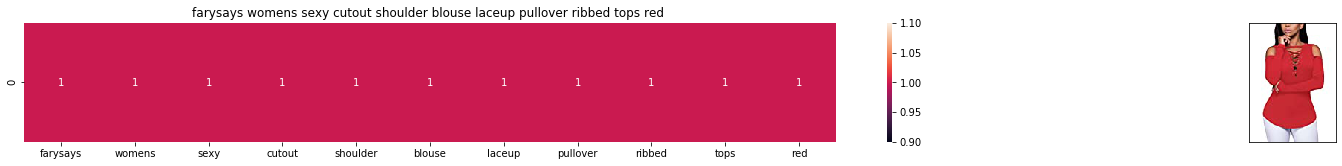

ASIN : B01M5JDF1B
Brand: FARYSAYS
Title: farysays womens sexy cutout shoulder blouse laceup pullover ribbed tops red 
Euclidean similarity with the query image : 0.0


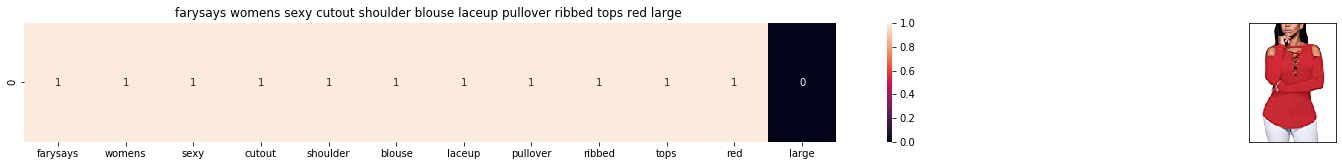

ASIN : B01M74UKHN
Brand: FARYSAYS
Title: farysays womens sexy cutout shoulder blouse laceup pullover ribbed tops red large 
Euclidean similarity with the query image : 1.0


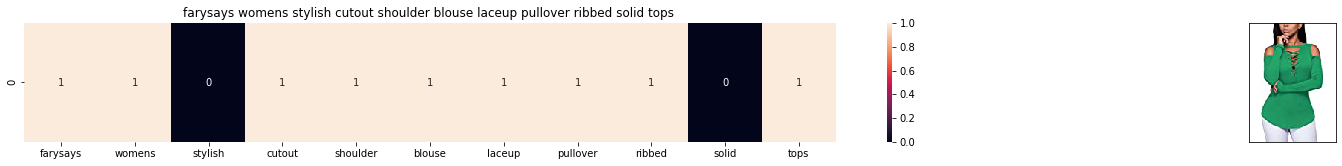

ASIN : B01M5JDIYD
Brand: FARYSAYS
Title: farysays womens stylish cutout shoulder blouse laceup pullover ribbed solid tops 
Euclidean similarity with the query image : 2.0


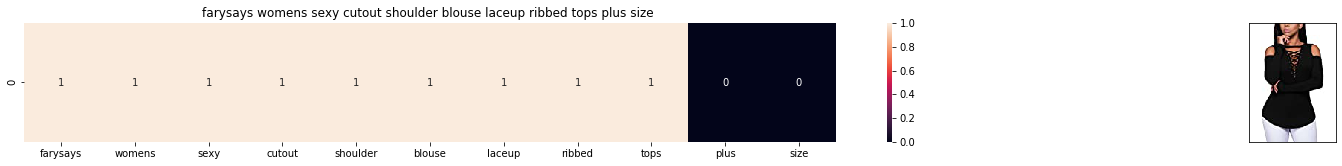

ASIN : B01M9J1FJC
Brand: FARYSAYS
Title: farysays womens sexy cutout shoulder blouse laceup ribbed tops plus size 
Euclidean similarity with the query image : 2.0


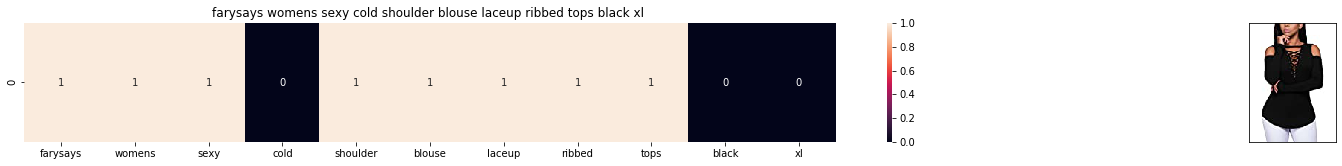

ASIN : B01M4R97JB
Brand: FARYSAYS
Title: farysays womens sexy cold shoulder blouse laceup ribbed tops black xl 
Euclidean similarity with the query image : 2.449489742783178


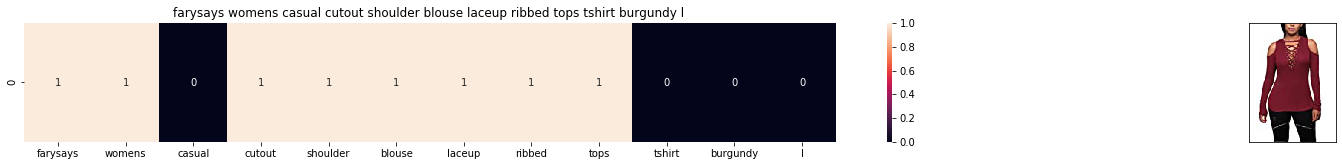

ASIN : B01MF6DSHE
Brand: FARYSAYS
Title: farysays womens casual cutout shoulder blouse laceup ribbed tops tshirt burgundy l 
Euclidean similarity with the query image : 2.449489742783178


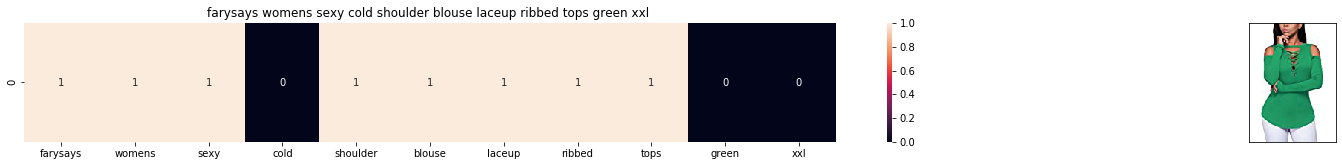

ASIN : B01M7XNEW5
Brand: FARYSAYS
Title: farysays womens sexy cold shoulder blouse laceup ribbed tops green xxl 
Euclidean similarity with the query image : 2.449489742783178


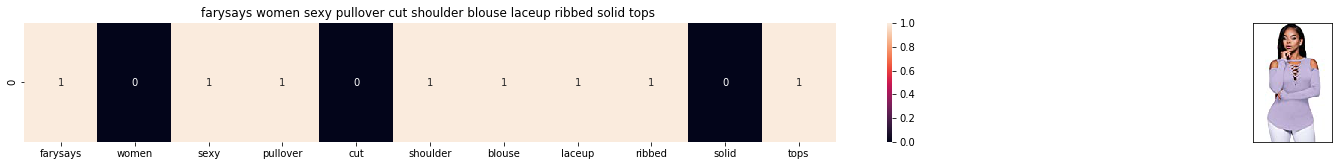

ASIN : B01M3XZVVY
Brand: FARYSAYS
Title: farysays women sexy pullover cut shoulder blouse laceup ribbed solid tops 
Euclidean similarity with the query image : 2.449489742783178


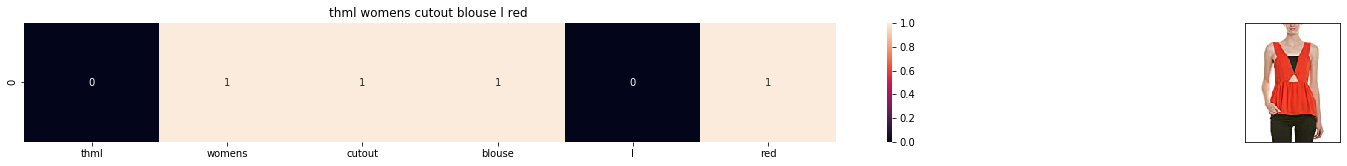

ASIN : B01MFC9BAZ
Brand: THML
Title: thml womens cutout blouse l red 
Euclidean similarity with the query image : 2.8284271247461903


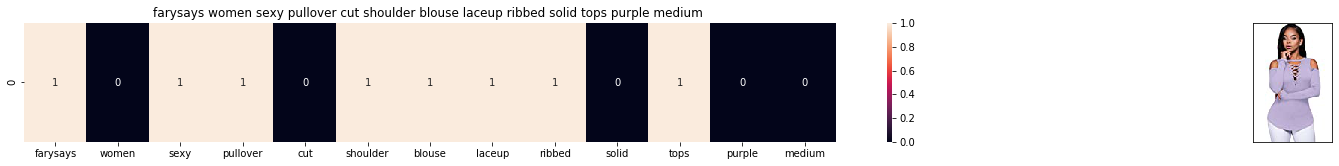

ASIN : B01M2CL6CB
Brand: FARYSAYS
Title: farysays women sexy pullover cut shoulder blouse laceup ribbed solid tops purple medium 
Euclidean similarity with the query image : 2.8284271247461903


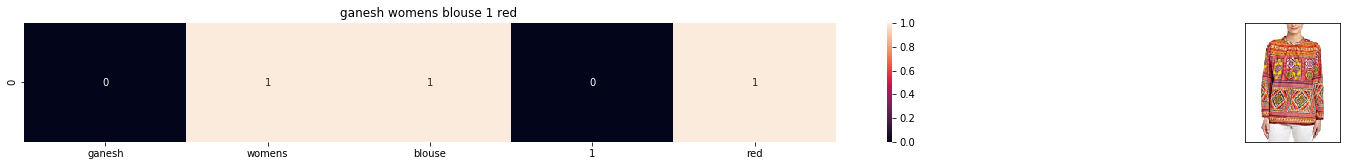

ASIN : B01N060XDP
Brand: Ganesh
Title: ganesh womens blouse 1 red 
Euclidean similarity with the query image : 3.0


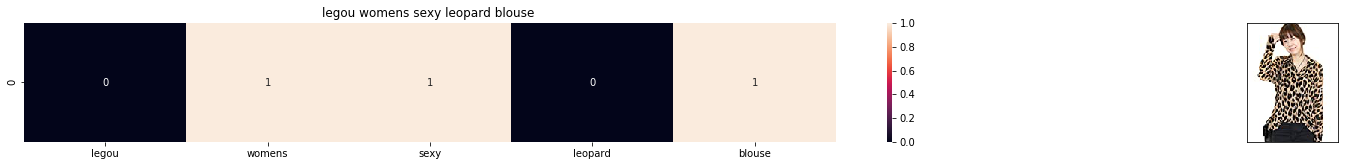

ASIN : B0142HAASS
Brand: Legou
Title: legou womens sexy leopard blouse 
Euclidean similarity with the query image : 3.1622776601683795


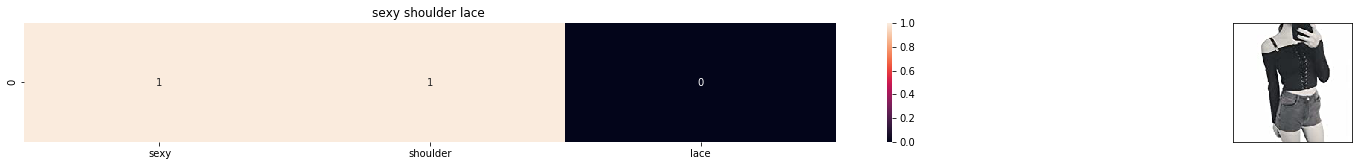

ASIN : B01JVWUB3S
Brand: bylexie
Title: sexy shoulder lace 
Euclidean similarity with the query image : 3.1622776601683795


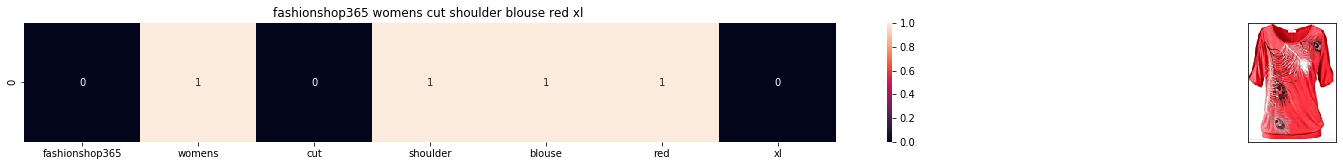

ASIN : B01HTR6LPO
Brand: FashionShop365
Title: fashionshop365 womens cut shoulder blouse red xl 
Euclidean similarity with the query image : 3.1622776601683795


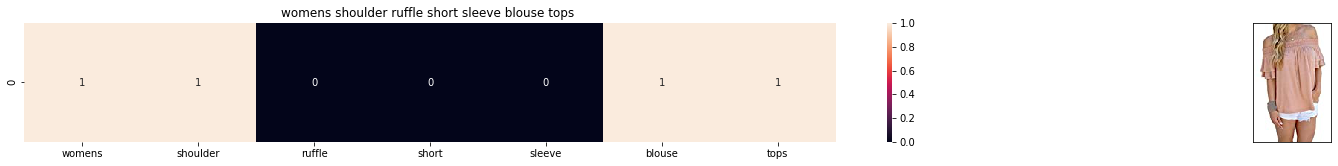

ASIN : B01KXEDMZC
Brand: ouwoow
Title: womens shoulder ruffle short sleeve blouse tops 
Euclidean similarity with the query image : 3.1622776601683795


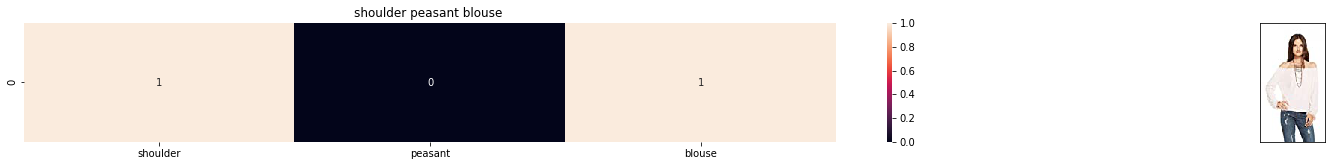

ASIN : B01E1QD5PK
Brand: CHASER
Title: shoulder peasant blouse 
Euclidean similarity with the query image : 3.1622776601683795


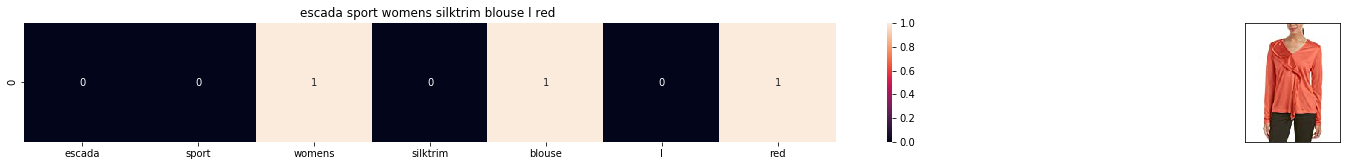

ASIN : B071XD1RZ6
Brand: Escada Sport
Title: escada sport womens silktrim blouse l red 
Euclidean similarity with the query image : 3.3166247903554


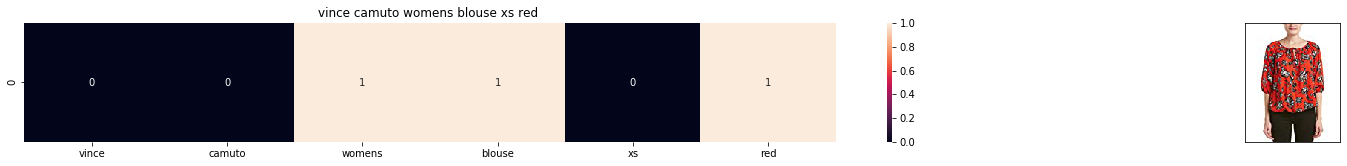

ASIN : B01NCDUQ7L
Brand: Vince Camuto
Title: vince camuto womens blouse xs red 
Euclidean similarity with the query image : 3.3166247903554


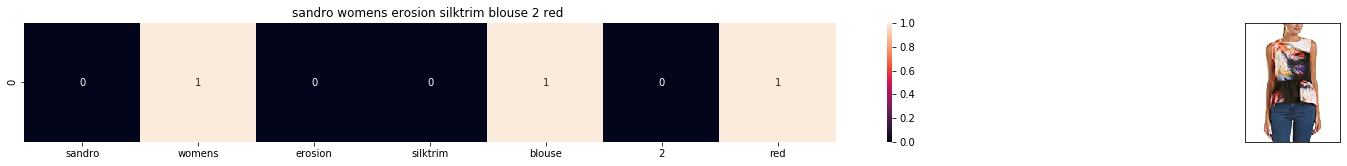

ASIN : B0745382H2
Brand: Sandro
Title: sandro womens erosion silktrim blouse 2 red 
Euclidean similarity with the query image : 3.3166247903554


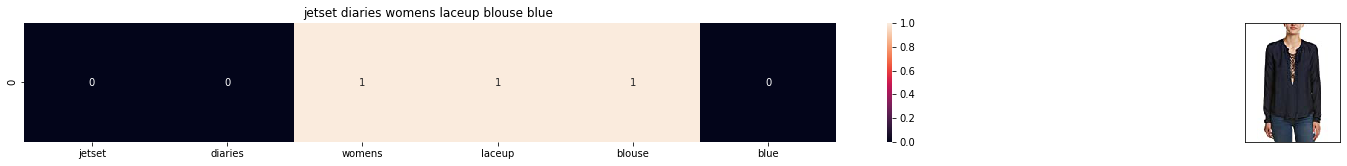

ASIN : B071GTZ236
Brand: The Jetset Diaries
Title: jetset diaries womens laceup blouse blue 
Euclidean similarity with the query image : 3.3166247903554


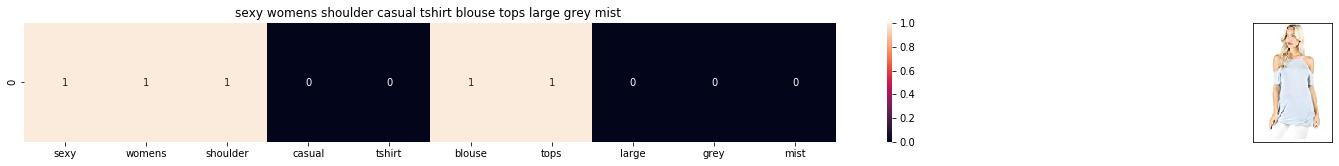

ASIN : B0756PG4B6
Brand: Kaylee
Title: sexy womens shoulder casual tshirt blouse tops large grey mist 
Euclidean similarity with the query image : 3.3166247903554


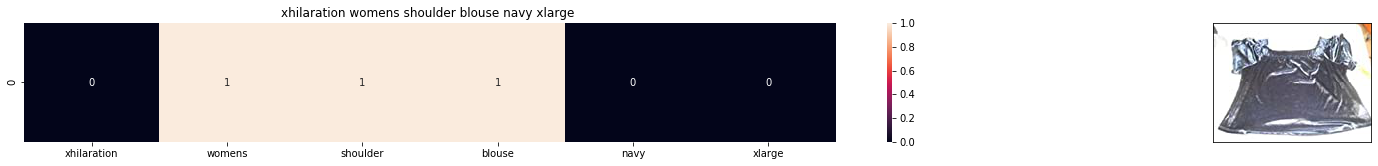

ASIN : B072M9TWSK
Brand: Xhilaration
Title: xhilaration womens shoulder blouse navy xlarge 
Euclidean similarity with the query image : 3.3166247903554


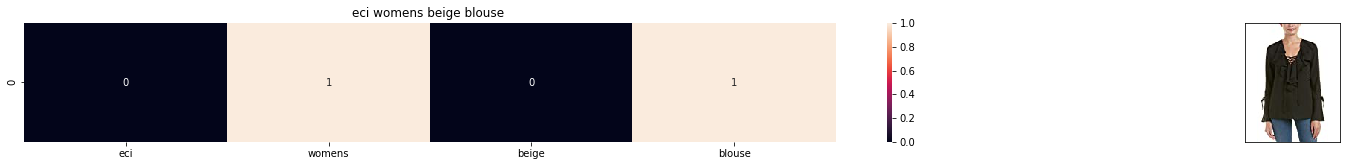

ASIN : B073VL1SQT
Brand: ECI New York
Title: eci womens beige blouse 
Euclidean similarity with the query image : 3.3166247903554


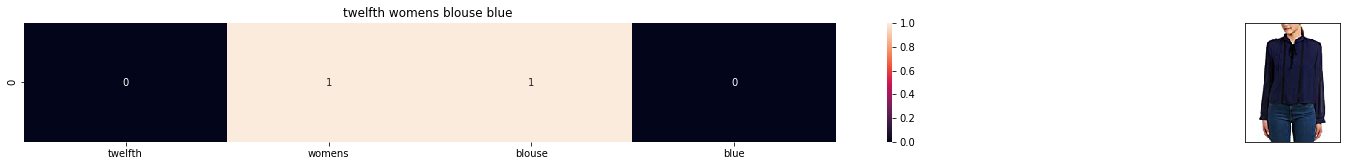

ASIN : B074F5BP5F
Brand: On Twelfth
Title: twelfth womens blouse blue 
Euclidean similarity with the query image : 3.3166247903554


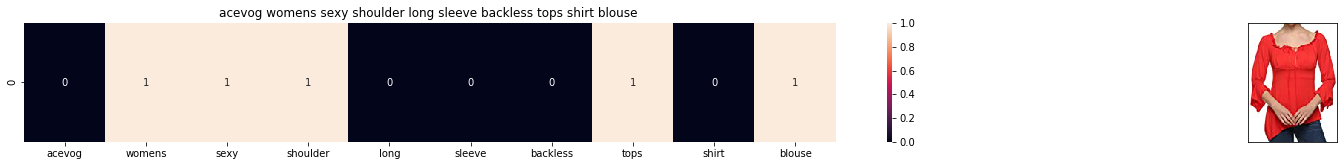

ASIN : B01CE4GGGG
Brand: ACEVOG
Title: acevog womens sexy shoulder long sleeve backless tops shirt blouse 
Euclidean similarity with the query image : 3.3166247903554


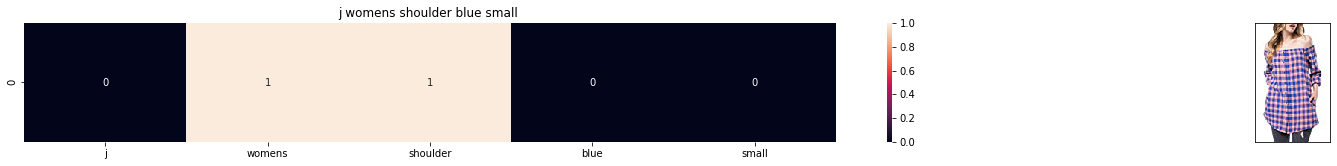

ASIN : B07583CQFT
Brand: Very J
Title: j womens shoulder blue small 
Euclidean similarity with the query image : 3.3166247903554


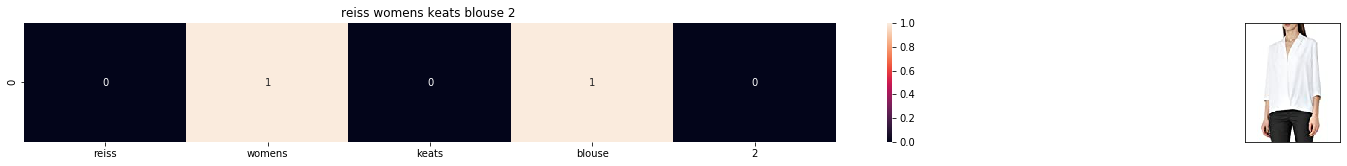

ASIN : B0741HDWGM
Brand: Reiss
Title: reiss womens keats blouse 2 
Euclidean similarity with the query image : 3.3166247903554


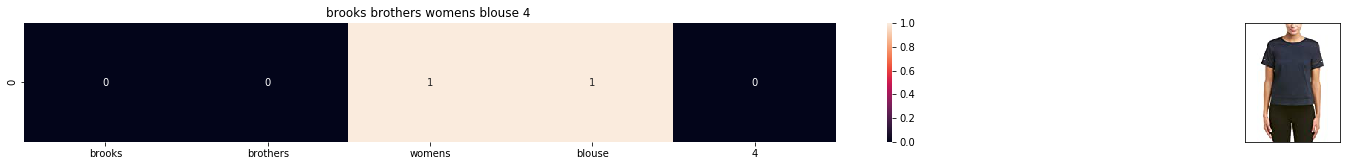

ASIN : B01M9FHVL3
Brand: Brooks Brothers
Title: brooks brothers womens blouse 4 
Euclidean similarity with the query image : 3.3166247903554


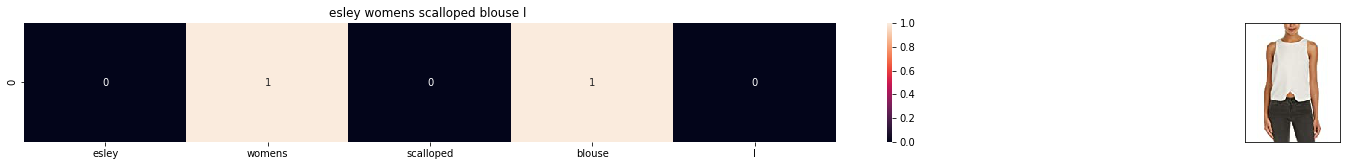

ASIN : B01M716OVC
Brand: Esley
Title: esley womens scalloped blouse l 
Euclidean similarity with the query image : 3.3166247903554


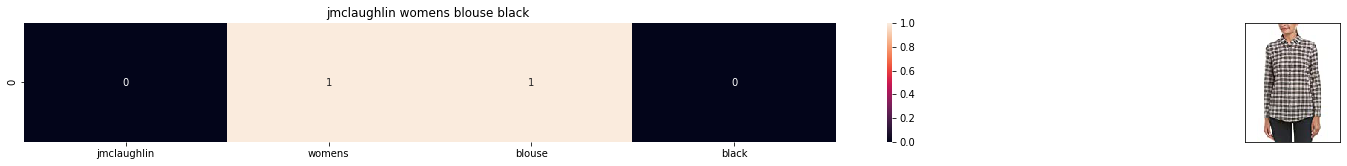

ASIN : B074KN55WS
Brand: J. McLaughlin
Title: jmclaughlin womens blouse black 
Euclidean similarity with the query image : 3.3166247903554


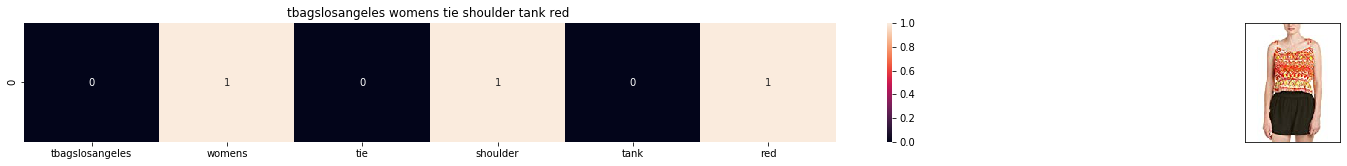

ASIN : B06XCDMW25
Brand: tbagslosangeles
Title: tbagslosangeles womens tie shoulder tank red 
Euclidean similarity with the query image : 3.3166247903554


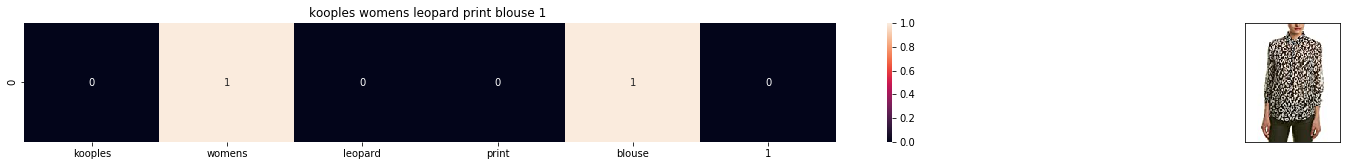

ASIN : B01N3KSWHR
Brand: The Kooples
Title: kooples womens leopard print blouse 1 
Euclidean similarity with the query image : 3.4641016151377544


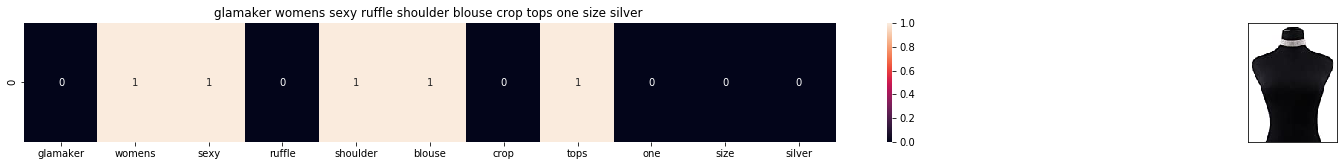

ASIN : B071G88V91
Brand: Glamaker
Title: glamaker womens sexy ruffle shoulder blouse crop tops one size silver 
Euclidean similarity with the query image : 3.4641016151377544


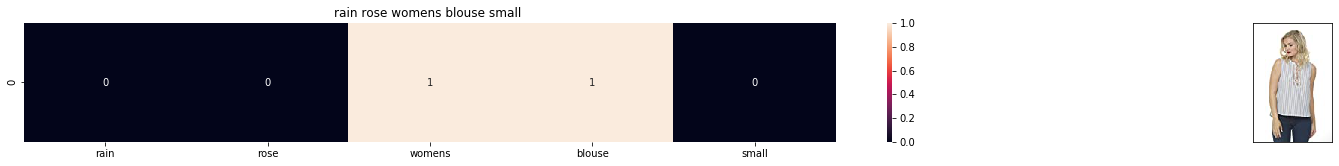

ASIN : B074JK3B4R
Brand: Rain
Title: rain rose womens blouse small 
Euclidean similarity with the query image : 3.4641016151377544


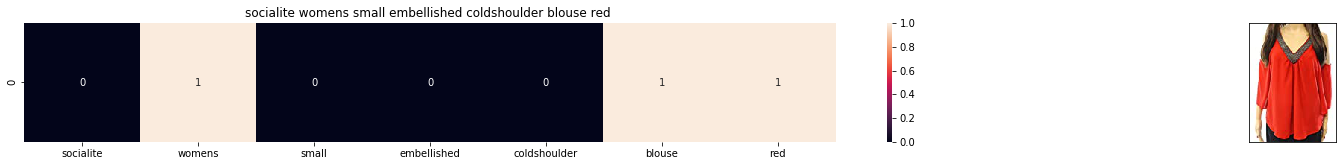

ASIN : B06XFT55PN
Brand: Socialite
Title: socialite womens small embellished coldshoulder blouse red 
Euclidean similarity with the query image : 3.4641016151377544


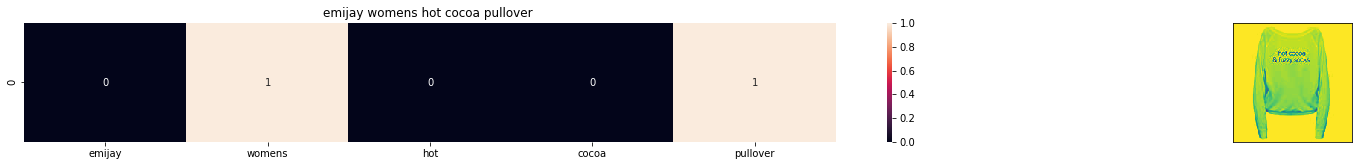

ASIN : B0187VHH0O
Brand: Emi Jay
Title: emijay womens hot cocoa pullover 
Euclidean similarity with the query image : 3.4641016151377544


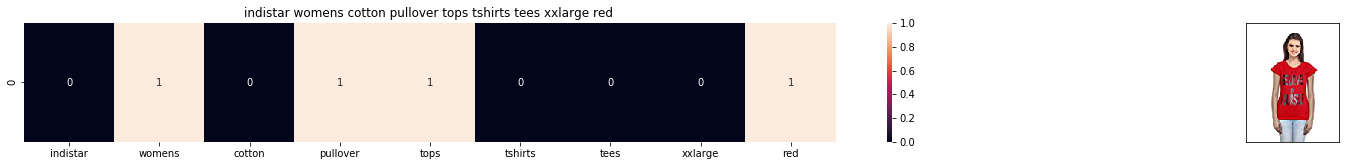

ASIN : B01DBMWKAQ
Brand: Indistar
Title: indistar womens cotton pullover tops tshirts tees xxlarge red 
Euclidean similarity with the query image : 3.4641016151377544


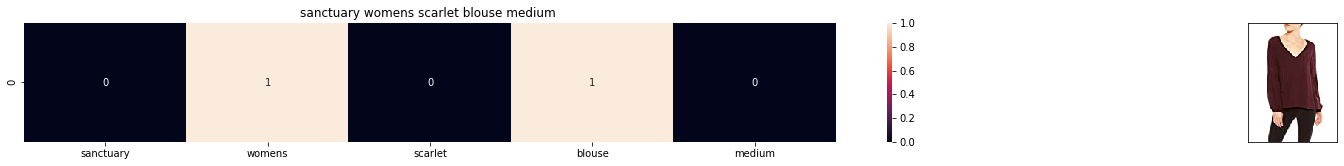

ASIN : B01NAR8CE0
Brand: Sactuary
Title: sanctuary womens scarlet blouse medium 
Euclidean similarity with the query image : 3.4641016151377544


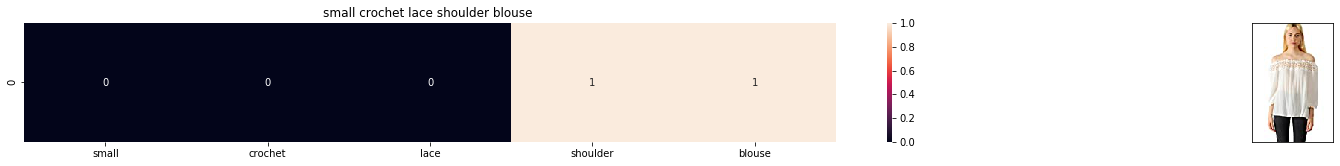

ASIN : B01N7WS5C9
Brand: Girl Evolution
Title: small crochet lace shoulder blouse 
Euclidean similarity with the query image : 3.4641016151377544


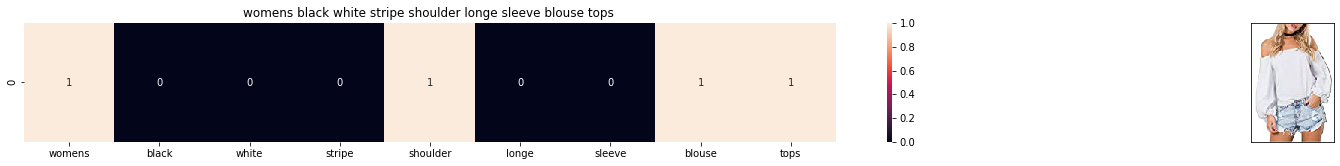

ASIN : B01KO8HUV4
Brand: ouwoow
Title: womens black white stripe shoulder longe sleeve blouse tops 
Euclidean similarity with the query image : 3.4641016151377544


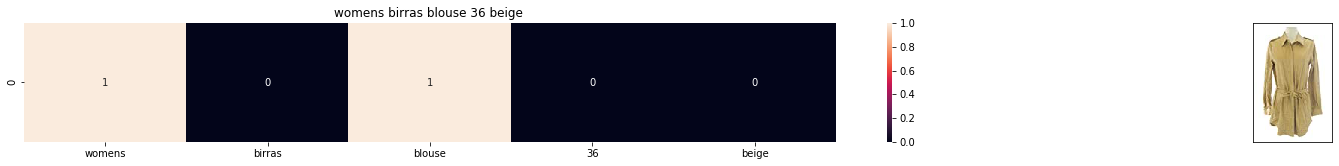

ASIN : B0184RMZBM
Brand: Super Trash
Title: womens birras blouse 36 beige 
Euclidean similarity with the query image : 3.4641016151377544


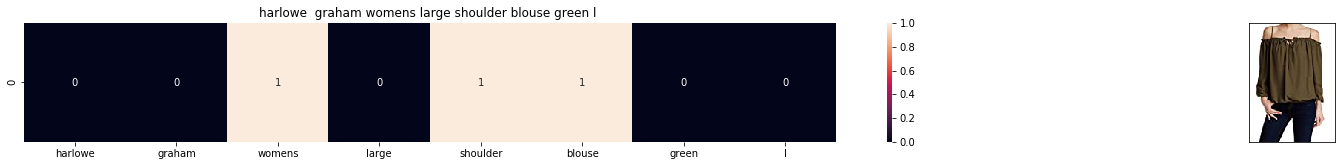

ASIN : B06XBY3NS3
Brand: Harlowe & Graham
Title: harlowe  graham womens large shoulder blouse green l 
Euclidean similarity with the query image : 3.4641016151377544


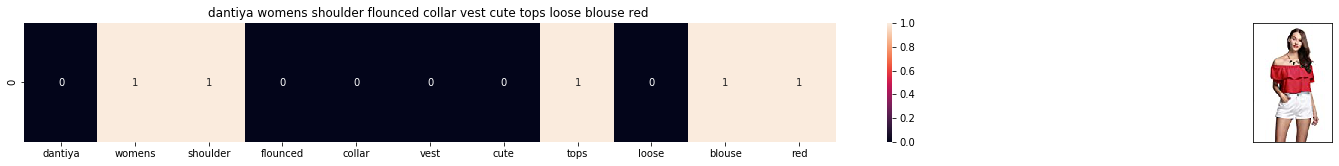

ASIN : B01L6V015A
Brand: Dantiya
Title: dantiya womens shoulder flounced collar vest cute tops loose blouse red 
Euclidean similarity with the query image : 3.4641016151377544


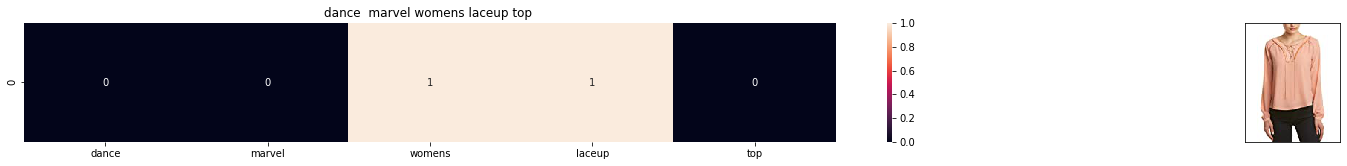

ASIN : B01M292S4C
Brand: Dance & Marvel
Title: dance  marvel womens laceup top 
Euclidean similarity with the query image : 3.4641016151377544


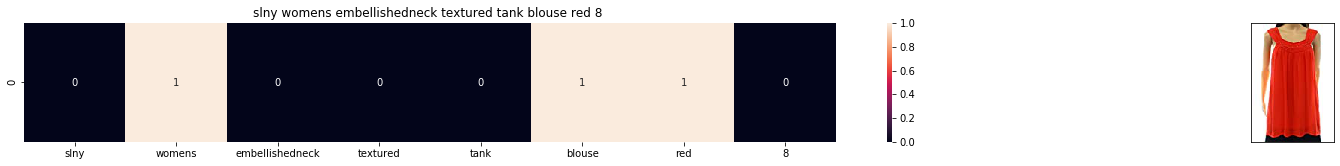

ASIN : B073S7BMR9
Brand: SLNY
Title: slny womens embellishedneck textured tank blouse red 8 
Euclidean similarity with the query image : 3.4641016151377544


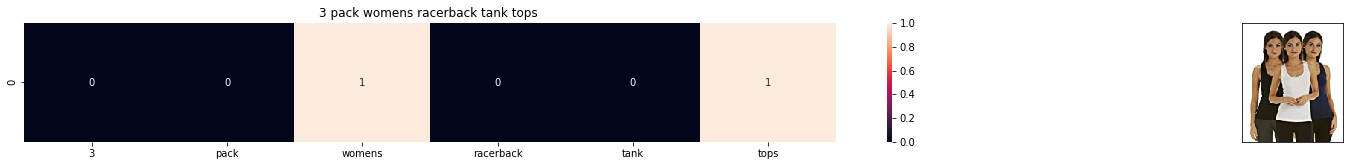

ASIN : B01MUAOXSN
Brand: Free to Live
Title: 3 pack womens racerback tank tops 
Euclidean similarity with the query image : 3.4641016151377544


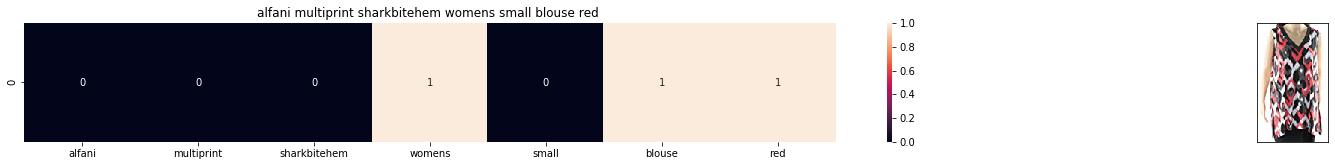

ASIN : B072MHBFTT
Brand: Alfani
Title: alfani multiprint sharkbitehem womens small blouse red 
Euclidean similarity with the query image : 3.4641016151377544


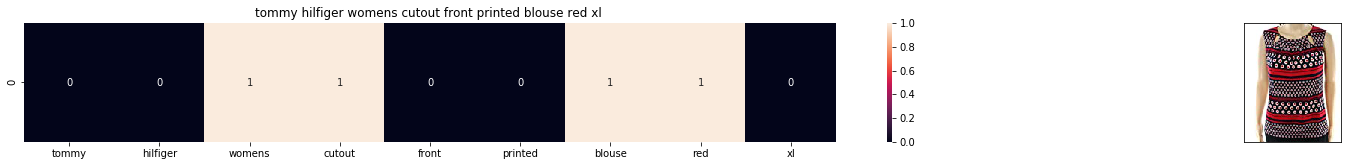

ASIN : B0747Z215C
Brand: Tommy Hilfiger
Title: tommy hilfiger womens cutout front printed blouse red xl 
Euclidean similarity with the query image : 3.4641016151377544


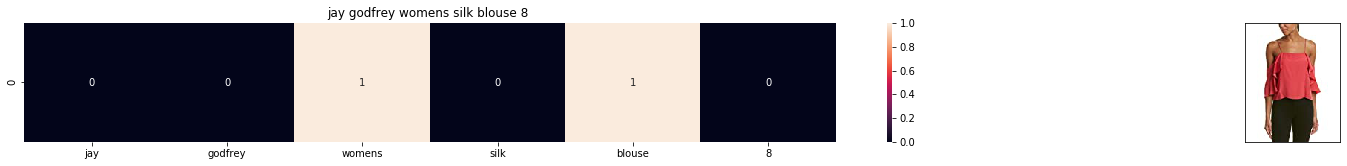

ASIN : B06XHKS3CP
Brand: Jay Godfrey
Title: jay godfrey womens silk blouse 8 
Euclidean similarity with the query image : 3.4641016151377544


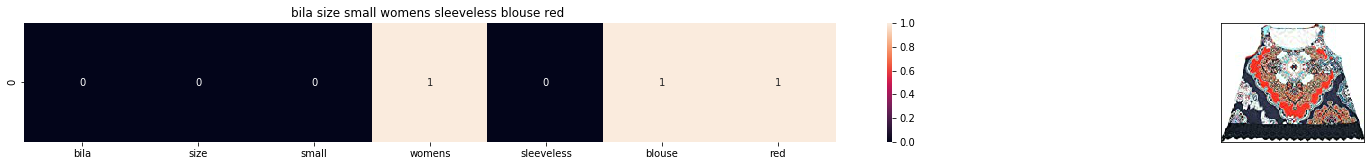

ASIN : B01L7ROZNC
Brand: Bila
Title: bila size small womens sleeveless blouse red 
Euclidean similarity with the query image : 3.4641016151377544


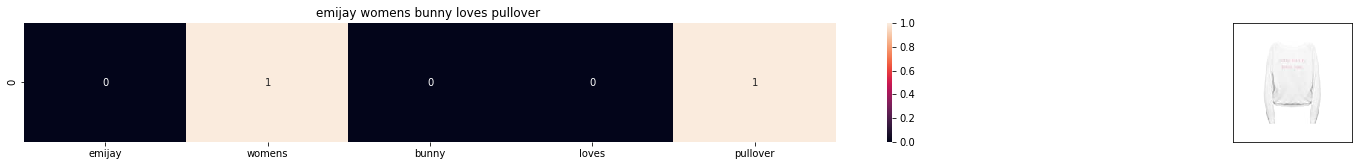

ASIN : B01BECWETM
Brand: Emi Jay
Title: emijay womens bunny loves pullover 
Euclidean similarity with the query image : 3.4641016151377544


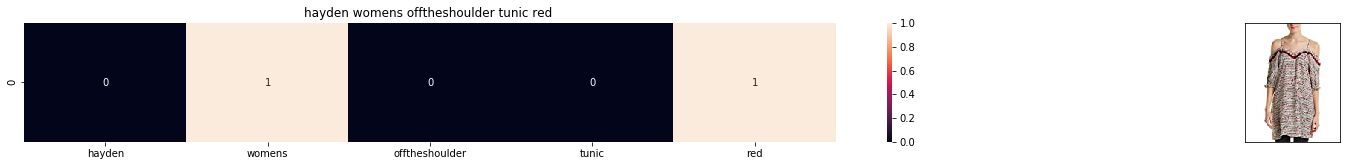

ASIN : B01N38H4DX
Brand: Hayden
Title: hayden womens offtheshoulder tunic red 
Euclidean similarity with the query image : 3.4641016151377544


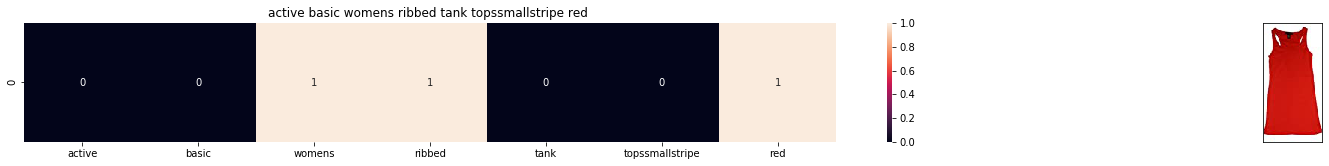

ASIN : B00LB7SRNI
Brand: Active Products
Title: active basic womens ribbed tank topssmallstripe red 
Euclidean similarity with the query image : 3.4641016151377544


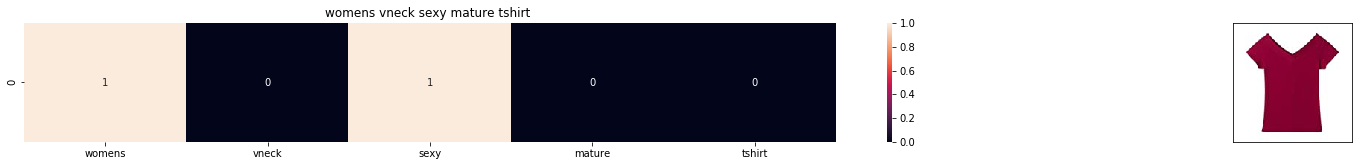

ASIN : B074KBRNX5
Brand: Sunshine
Title: womens vneck sexy mature tshirt 
Euclidean similarity with the query image : 3.4641016151377544


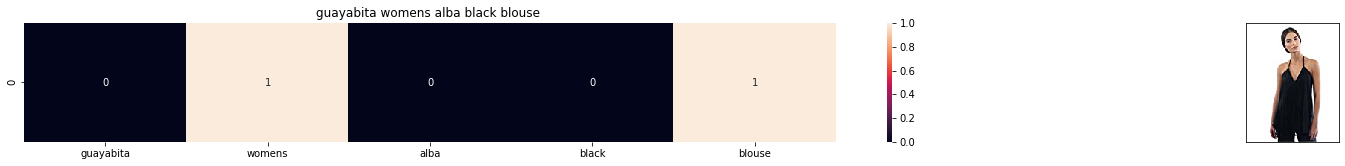

ASIN : B01JM4ZO3M
Brand: Guayabita
Title: guayabita womens alba black blouse 
Euclidean similarity with the query image : 3.4641016151377544


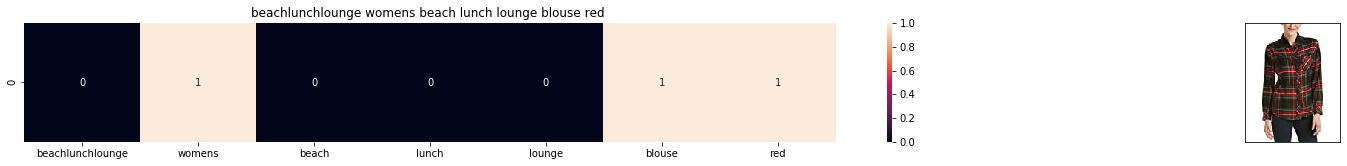

ASIN : B01NCVGO2S
Brand: Beach Lunch Lounge
Title: beachlunchlounge womens beach lunch lounge blouse red 
Euclidean similarity with the query image : 3.4641016151377544


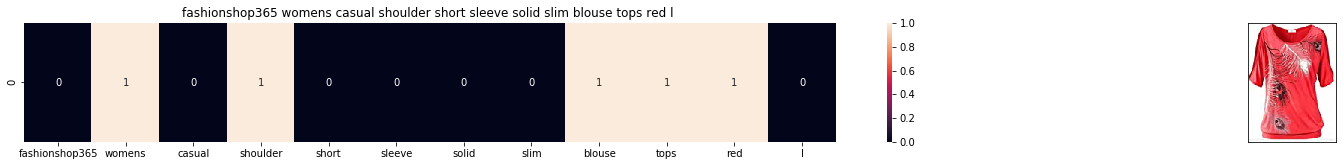

ASIN : B01HTR6KMI
Brand: FashionShop365
Title: fashionshop365 womens casual shoulder short sleeve solid slim blouse tops red l 
Euclidean similarity with the query image : 3.4641016151377544


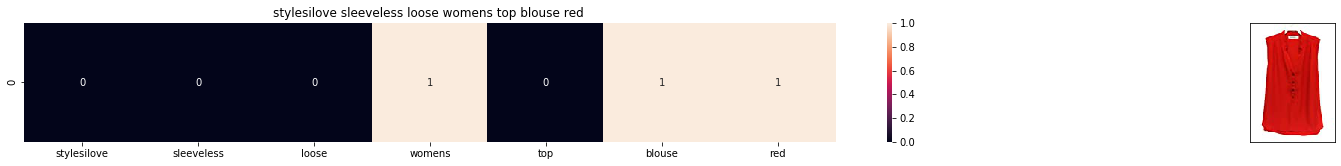

ASIN : B01JMU2RW2
Brand: stylesilove
Title: stylesilove sleeveless loose womens top blouse red 
Euclidean similarity with the query image : 3.4641016151377544


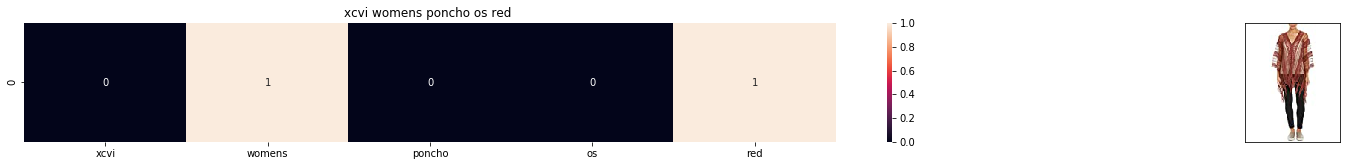

ASIN : B01M7U5BHH
Brand: XCVI
Title: xcvi womens poncho os red 
Euclidean similarity with the query image : 3.4641016151377544


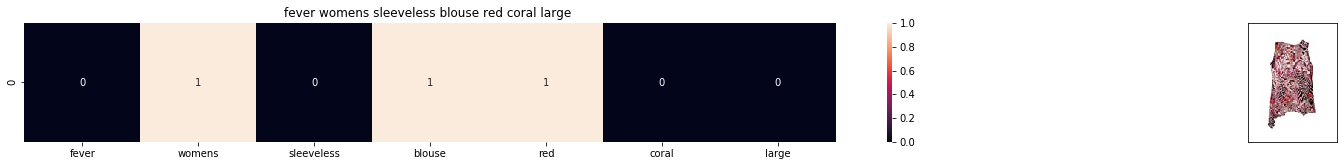

ASIN : B06XQ4ZCJK
Brand: Fever
Title: fever womens sleeveless blouse red coral large 
Euclidean similarity with the query image : 3.4641016151377544


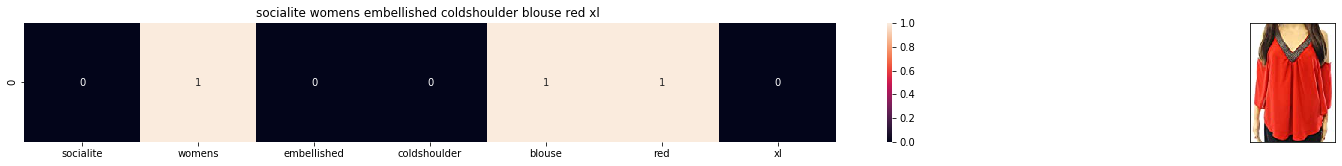

ASIN : B01M1RPRU4
Brand: Socialite
Title: socialite womens embellished coldshoulder blouse red xl 
Euclidean similarity with the query image : 3.4641016151377544


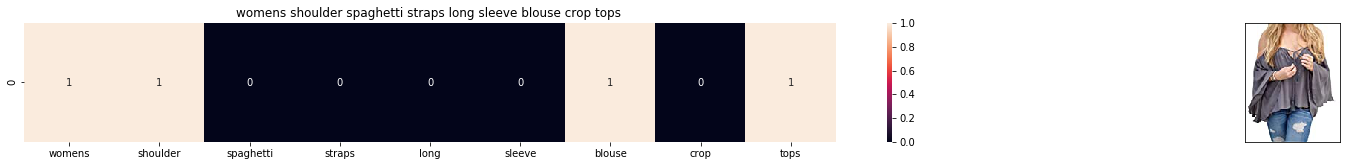

ASIN : B01G3KYY98
Brand: ouwoow
Title: womens shoulder spaghetti straps long sleeve blouse crop tops 
Euclidean similarity with the query image : 3.4641016151377544


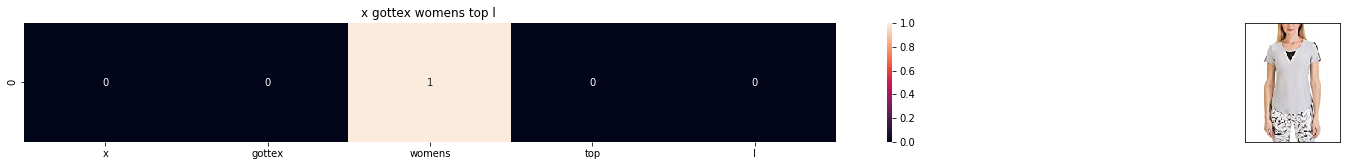

ASIN : B073M78XLP
Brand: X by Gottex
Title: x gottex womens top l 
Euclidean similarity with the query image : 3.4641016151377544


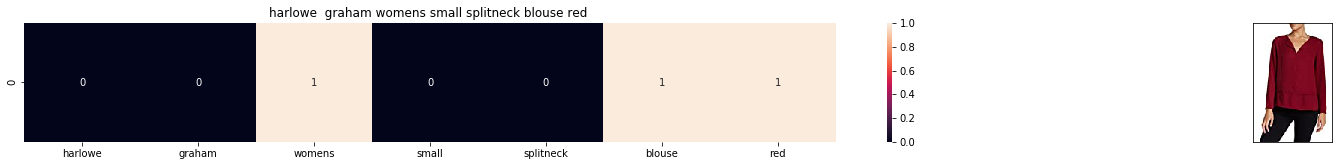

ASIN : B01JS7GV4O
Brand: Harlowe & Graham
Title: harlowe  graham womens small splitneck blouse red 
Euclidean similarity with the query image : 3.4641016151377544


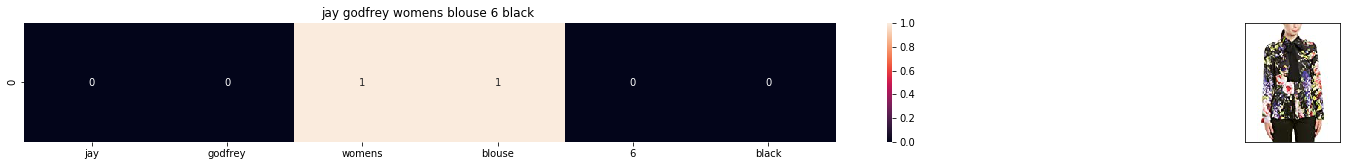

ASIN : B075B1NXKV
Brand: Jay Godfrey
Title: jay godfrey womens blouse 6 black 
Euclidean similarity with the query image : 3.4641016151377544


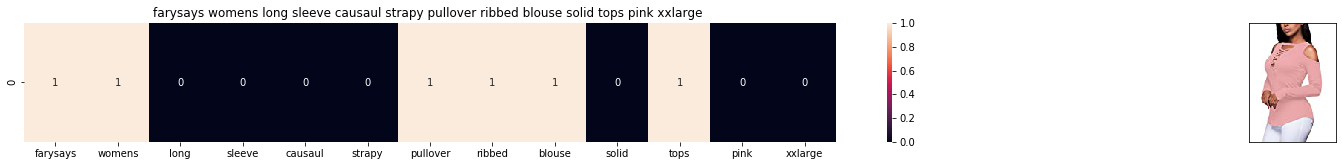

ASIN : B01M7XNT71
Brand: FARYSAYS
Title: farysays womens long sleeve causaul strapy pullover ribbed blouse solid tops pink xxlarge 
Euclidean similarity with the query image : 3.4641016151377544


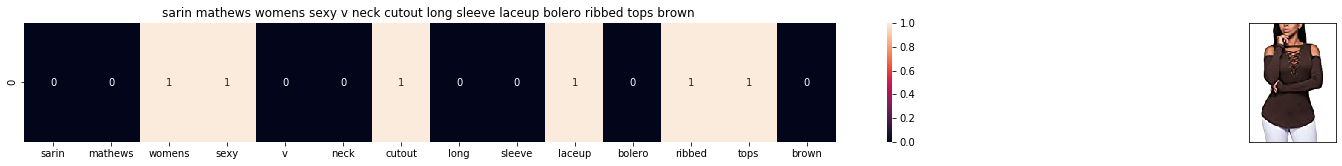

ASIN : B01HAFQ5S8
Brand: Sarin Mathews
Title: sarin mathews womens sexy v neck cutout long sleeve laceup bolero ribbed tops brown 
Euclidean similarity with the query image : 3.4641016151377544


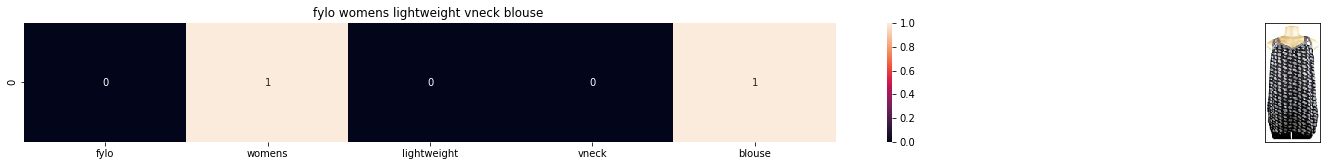

ASIN : B0743N8ZJM
Brand: Fylo
Title: fylo womens lightweight vneck blouse 
Euclidean similarity with the query image : 3.4641016151377544


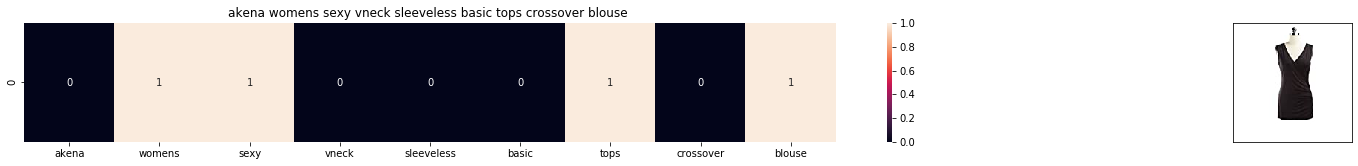

ASIN : B01N3Q2YOP
Brand: AKENA
Title: akena womens sexy vneck sleeveless basic tops crossover blouse 
Euclidean similarity with the query image : 3.4641016151377544


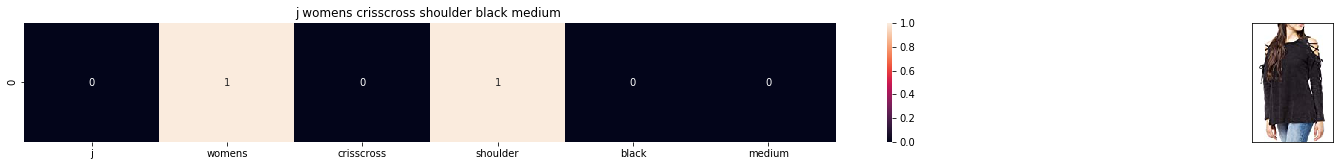

ASIN : B075836V69
Brand: Very J
Title: j womens crisscross shoulder black medium 
Euclidean similarity with the query image : 3.4641016151377544


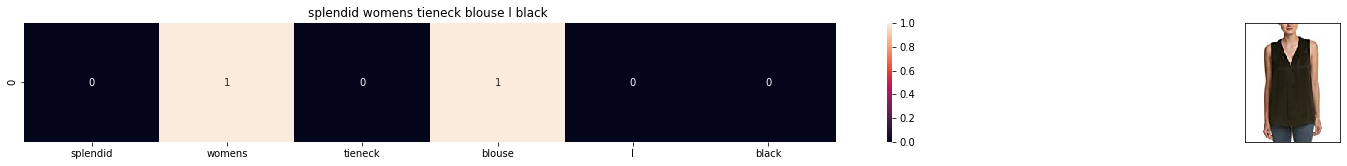

ASIN : B0716F4X2L
Brand: Splendid
Title: splendid womens tieneck blouse l black 
Euclidean similarity with the query image : 3.4641016151377544


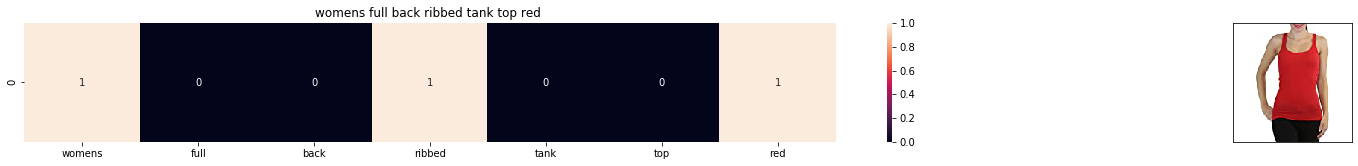

ASIN : B00SU6RLOO
Brand: Fornia Fashion
Title: womens full back ribbed tank top red 
Euclidean similarity with the query image : 3.4641016151377544


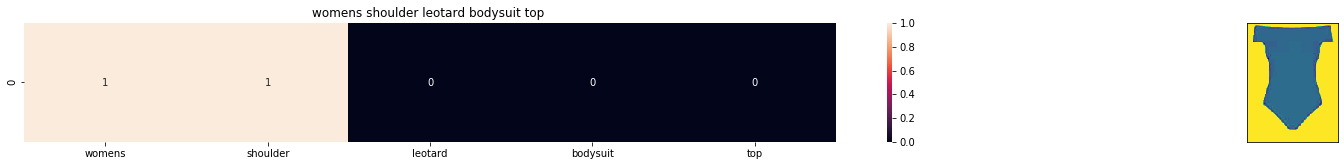

ASIN : B00TZVWBJ8
Brand: Fasion 4 Less
Title: womens shoulder leotard bodysuit top 
Euclidean similarity with the query image : 3.4641016151377544


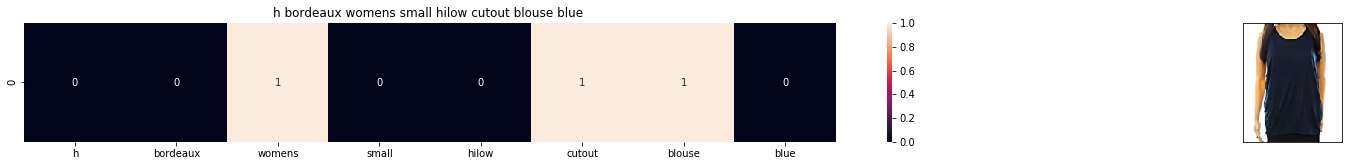

ASIN : B072JGWFX3
Brand: H By Bordeaux
Title: h bordeaux womens small hilow cutout blouse blue 
Euclidean similarity with the query image : 3.4641016151377544


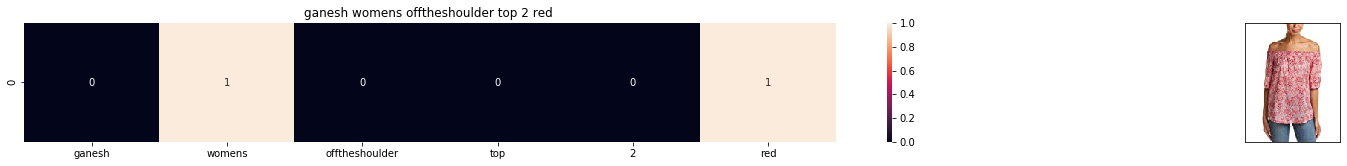

ASIN : B0711X3HCT
Brand: Ganesh
Title: ganesh womens offtheshoulder top 2 red 
Euclidean similarity with the query image : 3.4641016151377544


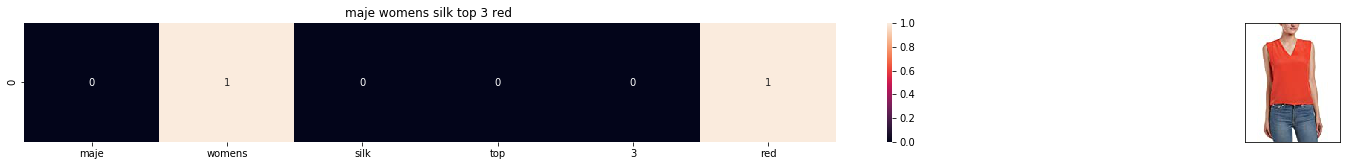

ASIN : B074517W14
Brand: Maje
Title: maje womens silk top 3 red 
Euclidean similarity with the query image : 3.4641016151377544


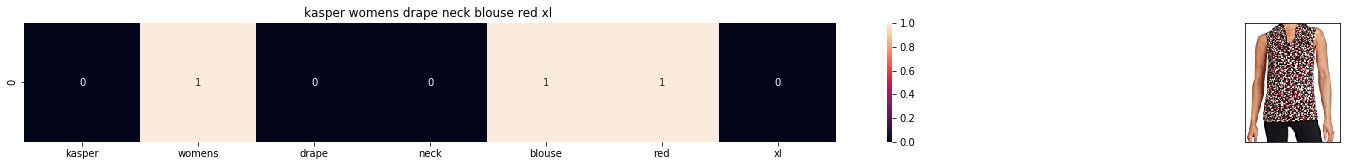

ASIN : B071FQWW8Q
Brand: Kasper
Title: kasper womens drape neck blouse red xl 
Euclidean similarity with the query image : 3.4641016151377544


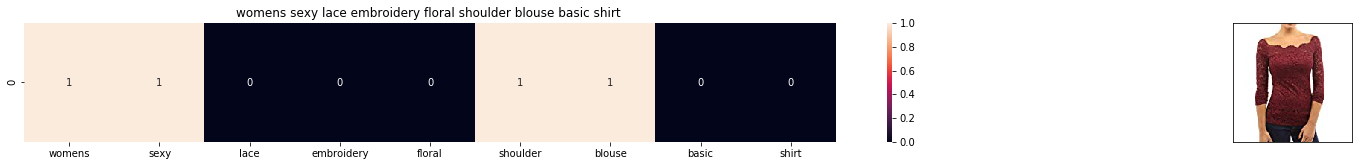

ASIN : B0755CJP2F
Brand: Rbwinner
Title: womens sexy lace embroidery floral shoulder blouse basic shirt 
Euclidean similarity with the query image : 3.4641016151377544


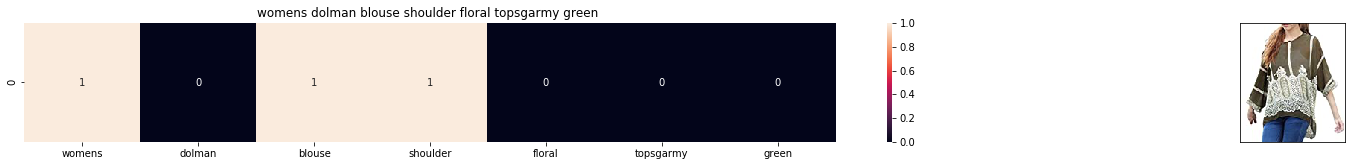

ASIN : B00ZR74EBW
Brand: AM CLOTHES
Title: womens dolman blouse shoulder floral topsgarmy green 
Euclidean similarity with the query image : 3.4641016151377544


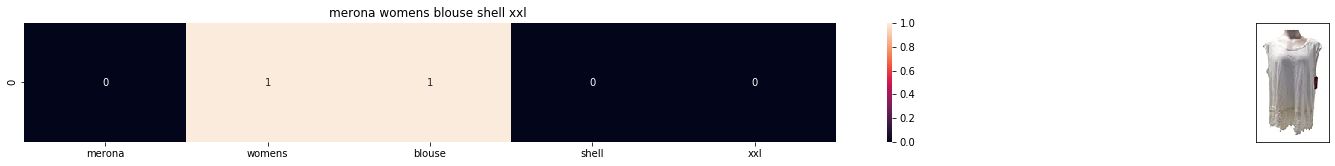

ASIN : B06ZYH5VXR
Brand: Merona
Title: merona womens blouse shell xxl 
Euclidean similarity with the query image : 3.4641016151377544


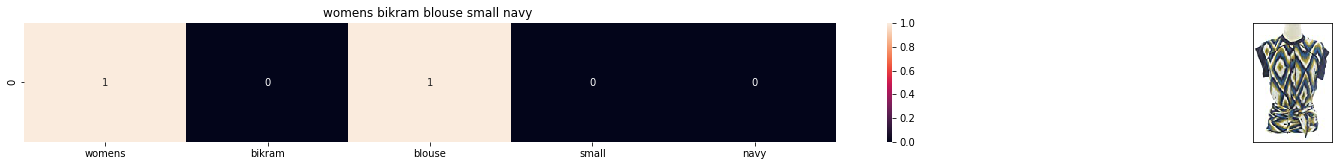

ASIN : B0184RN1JM
Brand: Super Trash
Title: womens bikram blouse small navy 
Euclidean similarity with the query image : 3.4641016151377544


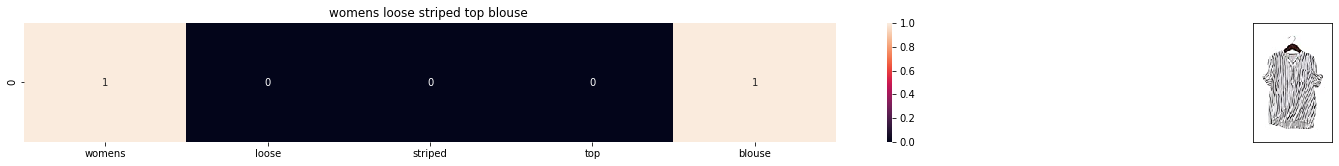

ASIN : B00ZZMYBRG
Brand: HP-LEISURE
Title: womens loose striped top blouse 
Euclidean similarity with the query image : 3.4641016151377544


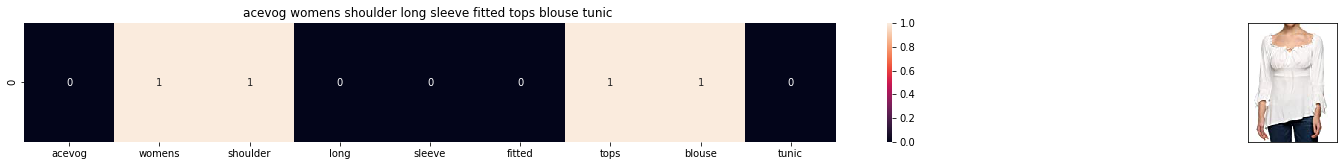

ASIN : B01CE4GMJW
Brand: ACEVOG
Title: acevog womens shoulder long sleeve fitted tops blouse tunic 
Euclidean similarity with the query image : 3.4641016151377544


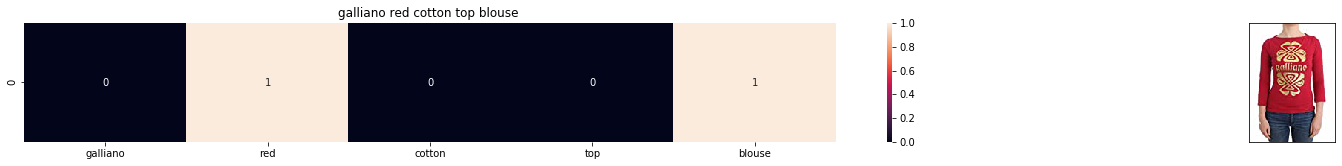

ASIN : B074G5HVJ1
Brand: Galliano
Title: galliano red cotton top blouse 
Euclidean similarity with the query image : 3.4641016151377544


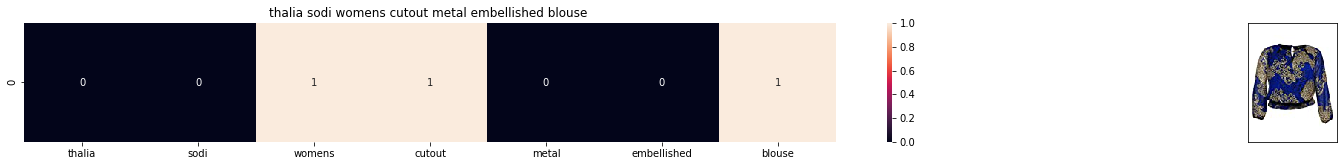

ASIN : B01MQHDB11
Brand: Thalia
Title: thalia sodi womens cutout metal embellished blouse 
Euclidean similarity with the query image : 3.4641016151377544


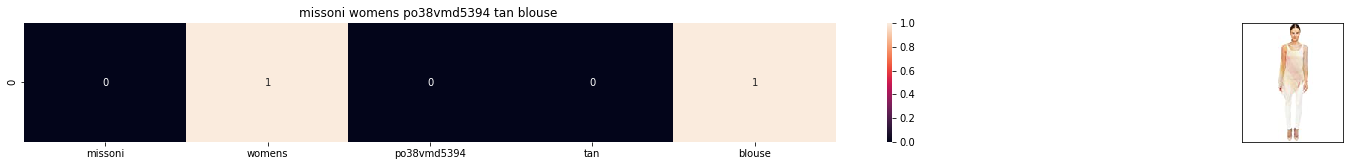

ASIN : B019NOTGGM
Brand: Missoni
Title: missoni womens po38vmd5394 tan blouse 
Euclidean similarity with the query image : 3.4641016151377544


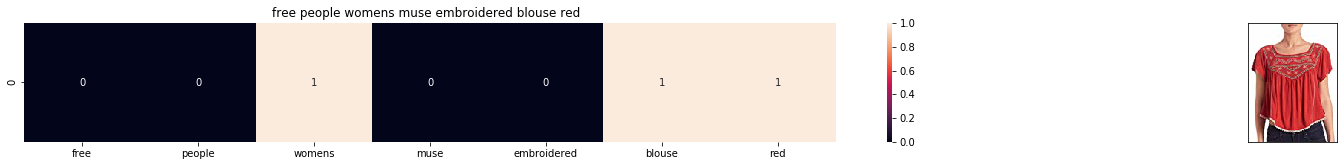

ASIN : B01IG69KHI
Brand: Free People
Title: free people womens muse embroidered blouse red  
Euclidean similarity with the query image : 3.4641016151377544


In [48]:
def bag_of_words_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]

    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

bag_of_words_model(124, 87) # change the index if you want to.


# TF-IDF product similarity

In [43]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

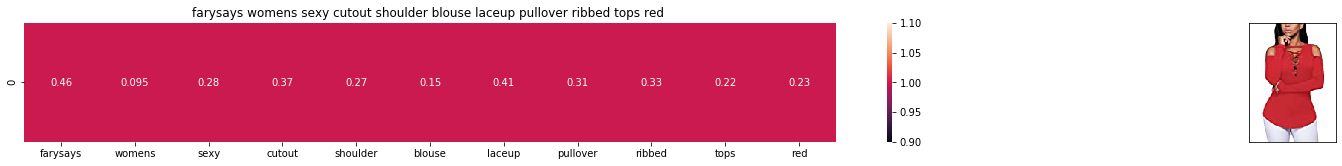

ASIN : B01M5JDF1B
BRAND : FARYSAYS
Eucliden distance from the given image : 0.0


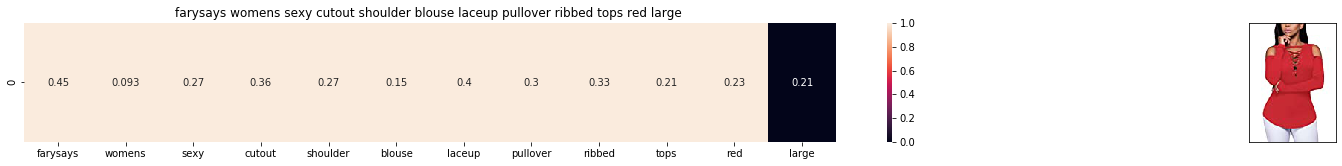

ASIN : B01M74UKHN
BRAND : FARYSAYS
Eucliden distance from the given image : 0.20627668928580162


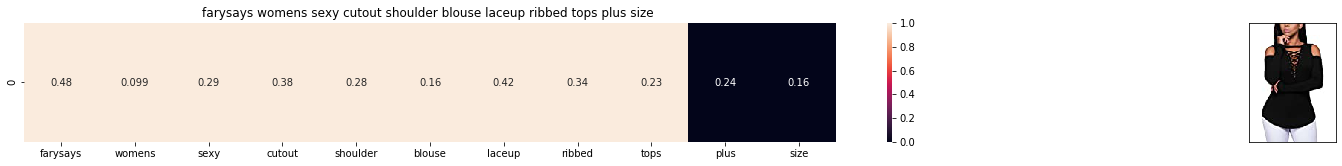

ASIN : B01M9J1FJC
BRAND : FARYSAYS
Eucliden distance from the given image : 0.4828578585742179


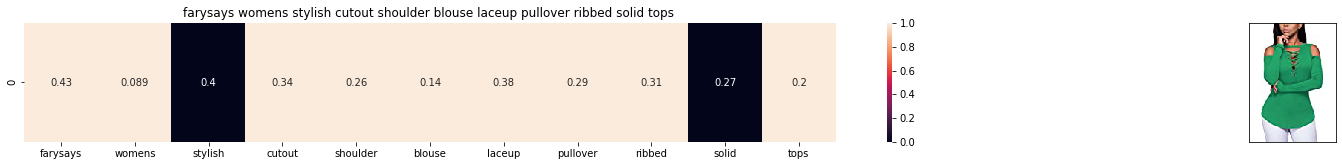

ASIN : B01M5JDIYD
BRAND : FARYSAYS
Eucliden distance from the given image : 0.6077204015852212


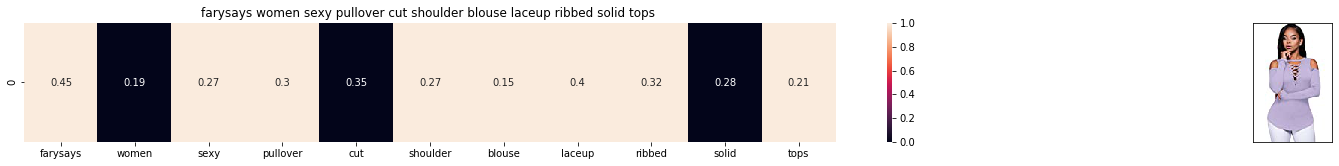

ASIN : B01M3XZVVY
BRAND : FARYSAYS
Eucliden distance from the given image : 0.6614261967775245


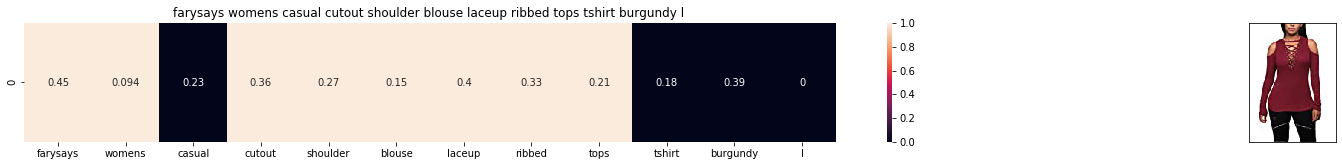

ASIN : B01MF6DSHE
BRAND : FARYSAYS
Eucliden distance from the given image : 0.6836995796510184


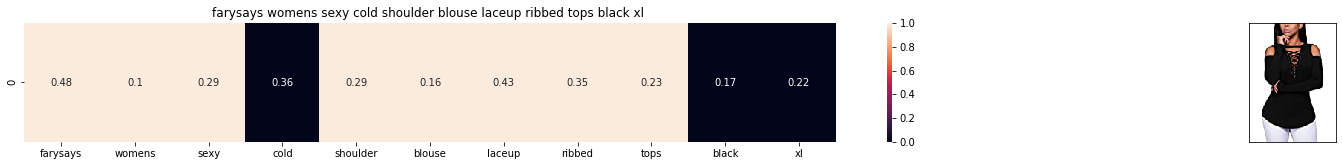

ASIN : B01M4R97JB
BRAND : FARYSAYS
Eucliden distance from the given image : 0.6993259700535296


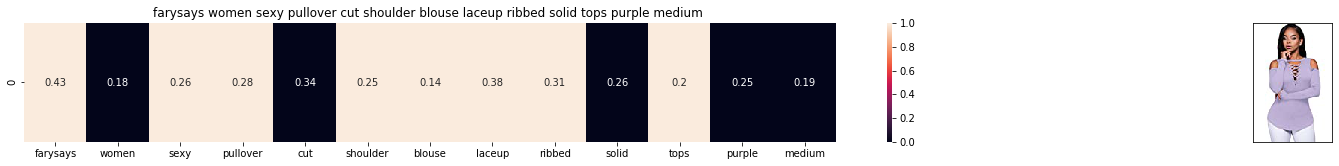

ASIN : B01M2CL6CB
BRAND : FARYSAYS
Eucliden distance from the given image : 0.7182397321898275


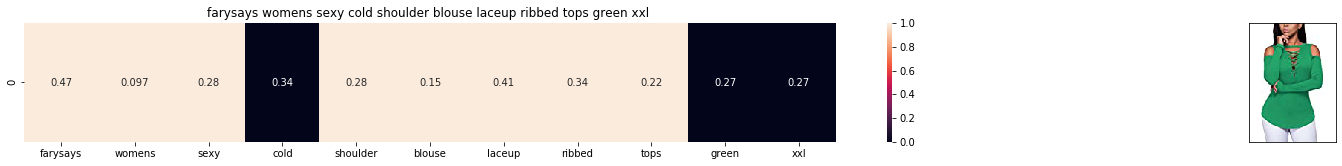

ASIN : B01M7XNEW5
BRAND : FARYSAYS
Eucliden distance from the given image : 0.7366582172453576


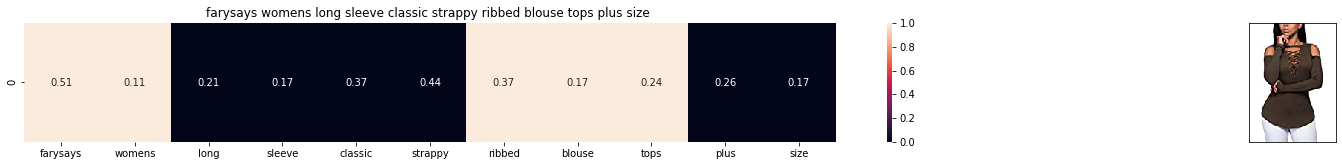

ASIN : B01MQD2T92
BRAND : FARYSAYS
Eucliden distance from the given image : 1.0529262055062305


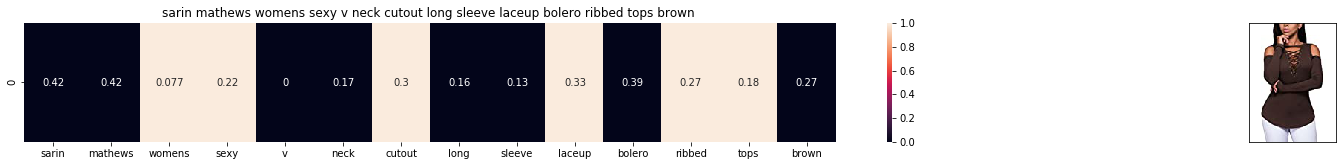

ASIN : B01HAFQ5S8
BRAND : Sarin Mathews
Eucliden distance from the given image : 1.0592233715061816


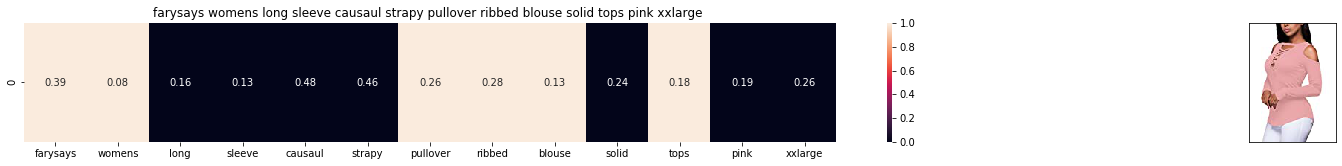

ASIN : B01M7XNT71
BRAND : FARYSAYS
Eucliden distance from the given image : 1.0796796349590805


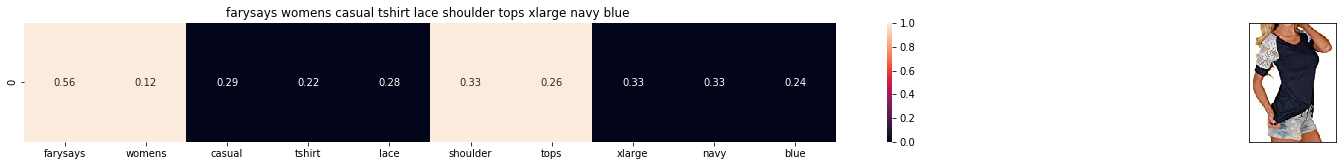

ASIN : B0717BMMV8
BRAND : FARYSAYS
Eucliden distance from the given image : 1.0803877988595005


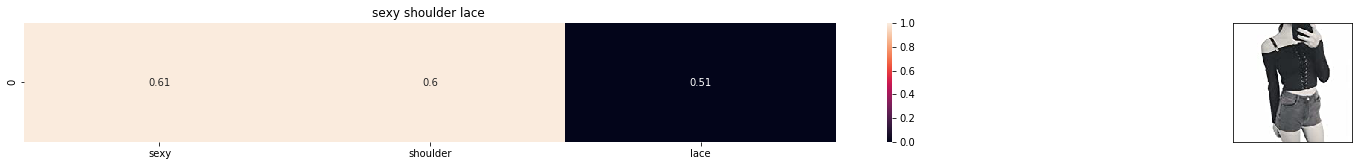

ASIN : B01JVWUB3S
BRAND : bylexie
Eucliden distance from the given image : 1.1546730049936083


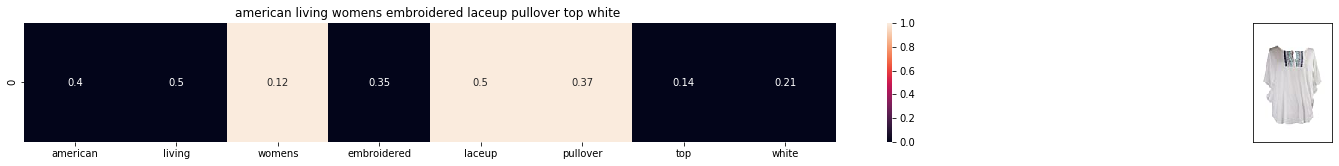

ASIN : B01NANU2KU
BRAND : American Home Living
Eucliden distance from the given image : 1.1592559266416822


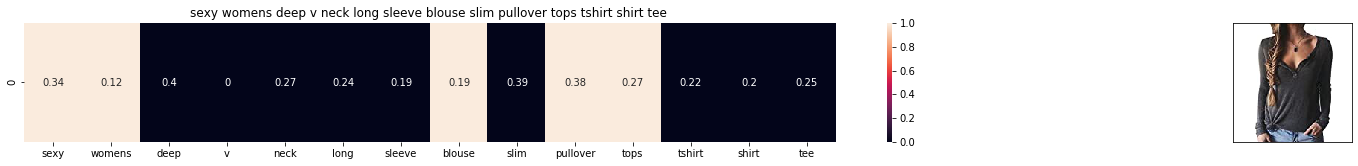

ASIN : B016UMLKIW
BRAND : Innovateyfm
Eucliden distance from the given image : 1.1777024125679616


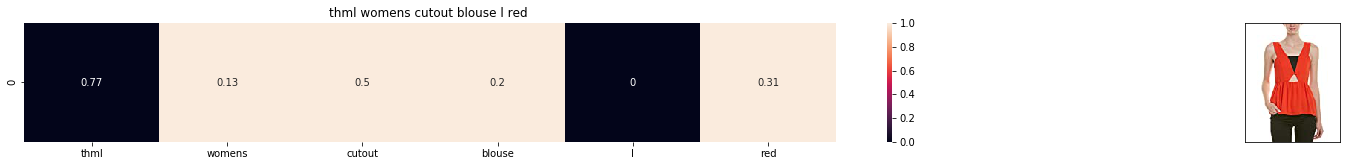

ASIN : B01MFC9BAZ
BRAND : THML
Eucliden distance from the given image : 1.1851127729206377


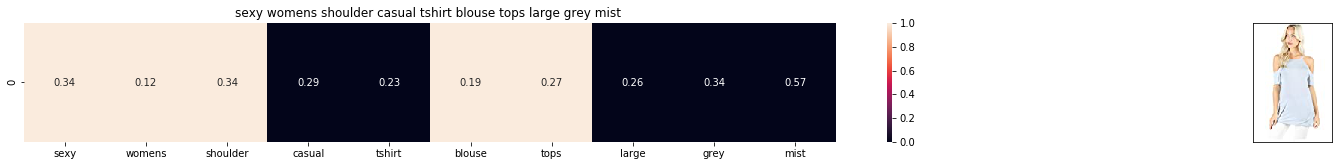

ASIN : B0756PG4B6
BRAND : Kaylee
Eucliden distance from the given image : 1.1952710763136725


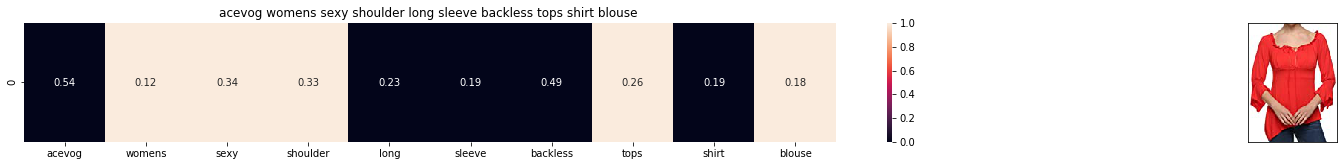

ASIN : B01CE4GGGG
BRAND : ACEVOG
Eucliden distance from the given image : 1.2009848796712177


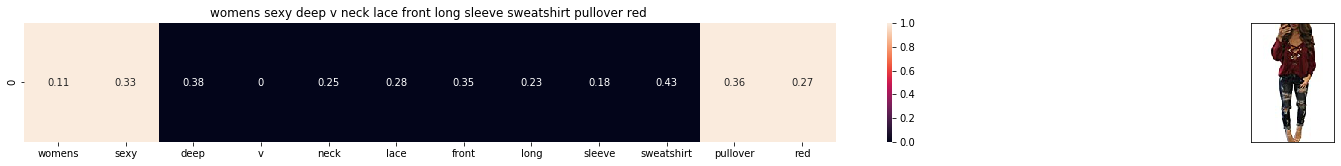

ASIN : B01MSNI226
BRAND : Oops Style
Eucliden distance from the given image : 1.2041593306971932


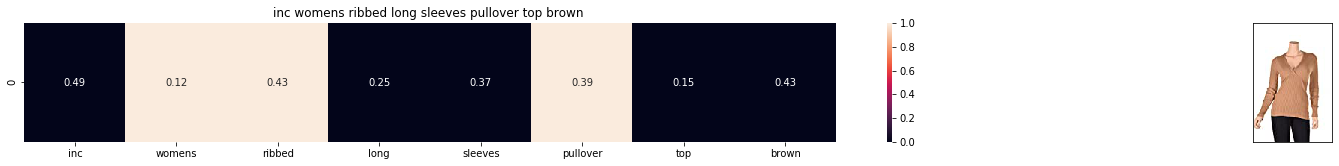

ASIN : B010OVNTHA
BRAND : INC International Concepts
Eucliden distance from the given image : 1.204790579300728


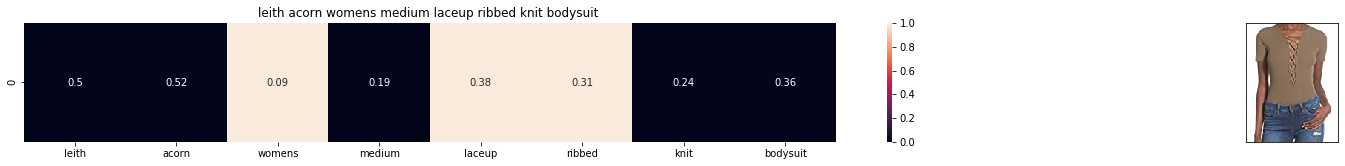

ASIN : B0758X773T
BRAND : Leith
Eucliden distance from the given image : 1.2082013837087469


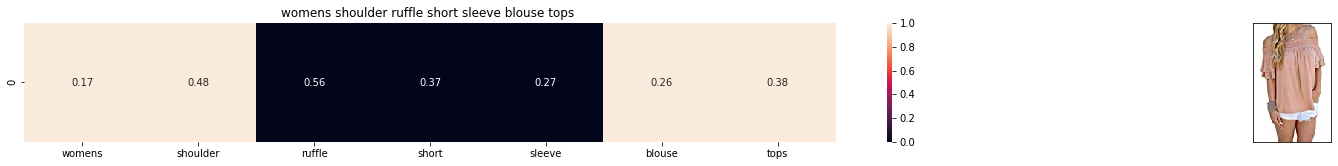

ASIN : B01KXEDMZC
BRAND : ouwoow
Eucliden distance from the given image : 1.2086501880089067


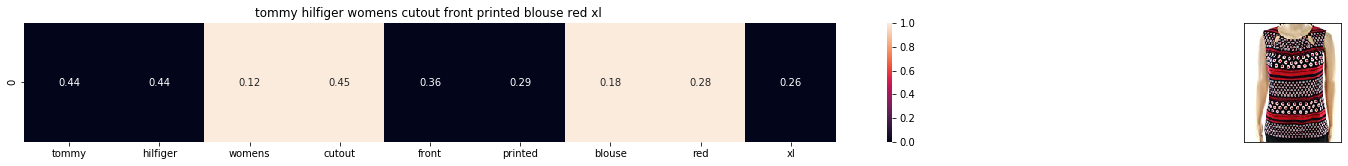

ASIN : B0747Z215C
BRAND : Tommy Hilfiger
Eucliden distance from the given image : 1.2094782154681545


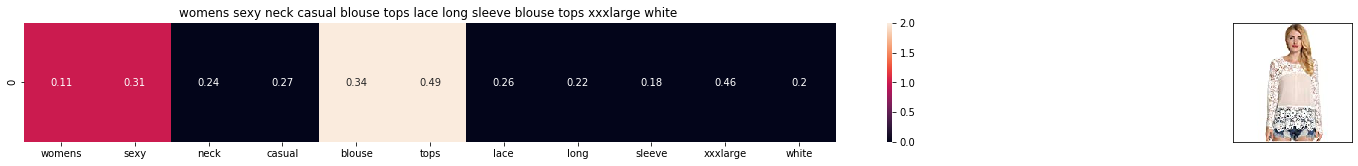

ASIN : B06XSZH7SY
BRAND : Kedera
Eucliden distance from the given image : 1.2205018612028848


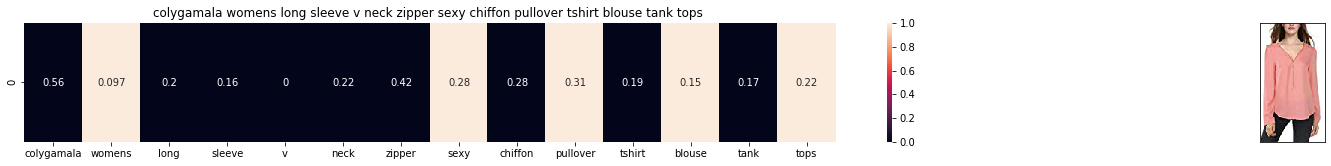

ASIN : B06X9NQFXB
BRAND : Colygamala
Eucliden distance from the given image : 1.221866481124312


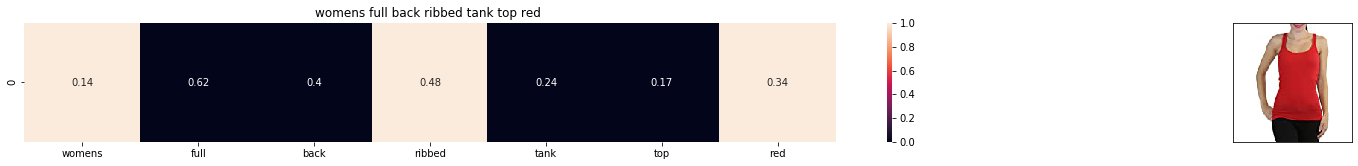

ASIN : B00SU6RLOO
BRAND : Fornia Fashion
Eucliden distance from the given image : 1.2236545407873796


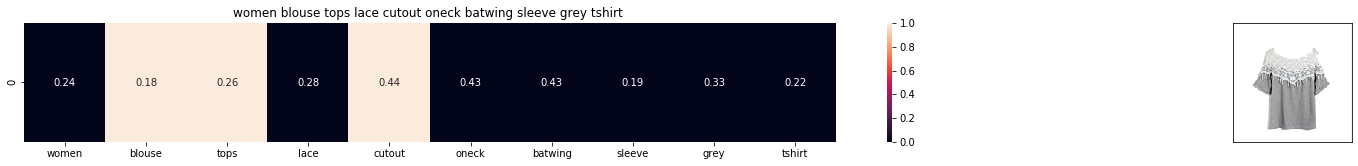

ASIN : B0759BFJ9S
BRAND : ECYC
Eucliden distance from the given image : 1.2266636369517756


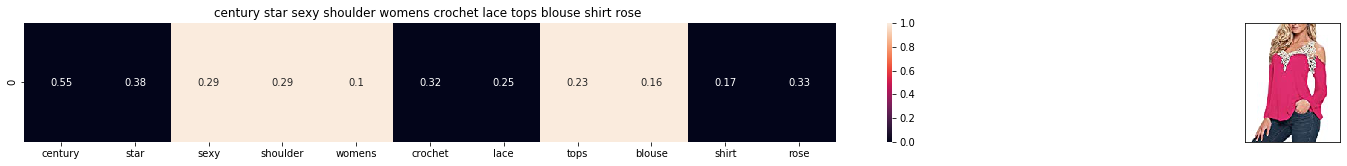

ASIN : B01J0OJQIS
BRAND : Century Star
Eucliden distance from the given image : 1.2305809783387838


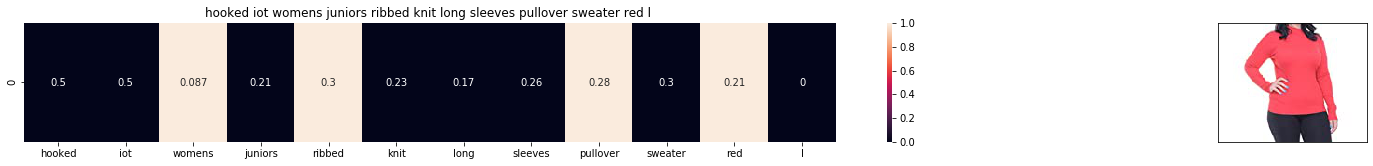

ASIN : B01MR3QDQ0
BRAND : Hooked Up
Eucliden distance from the given image : 1.2307003287036156


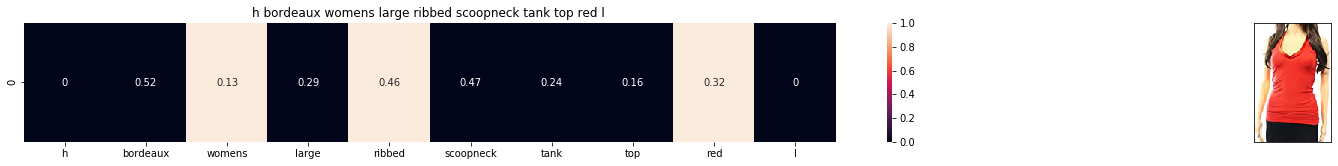

ASIN : B071W19QVB
BRAND : H By Bordeaux
Eucliden distance from the given image : 1.2308459735288428


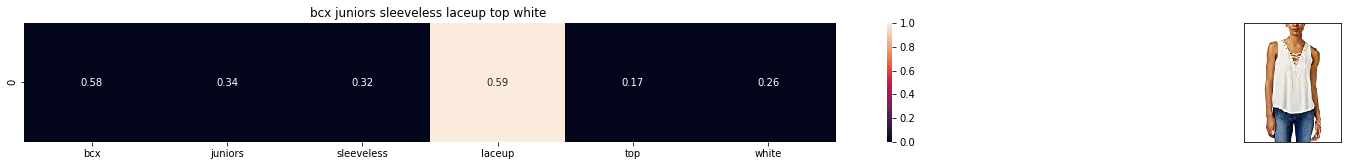

ASIN : B0713P6PKP
BRAND : BCX
Eucliden distance from the given image : 1.2314455062894183


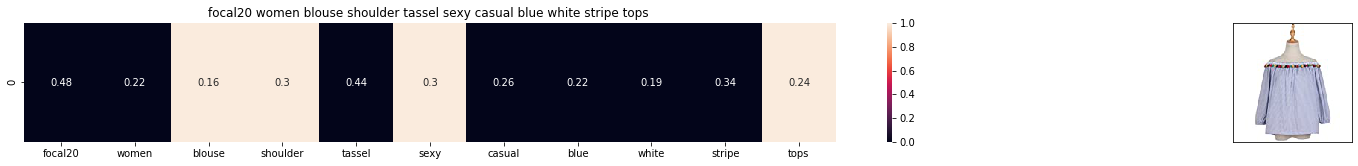

ASIN : B06XV6VFVC
BRAND : Focal20
Eucliden distance from the given image : 1.231548647407696


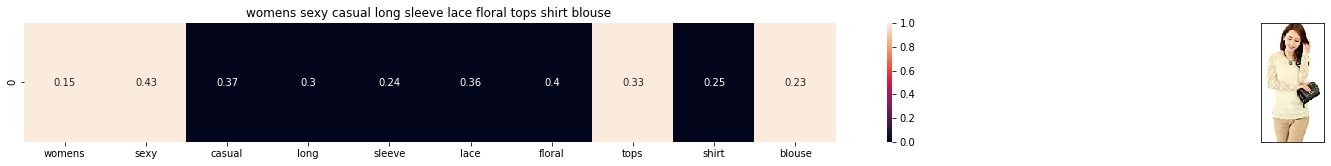

ASIN : B00NKVCVDA
BRAND : ACEFAST INC
Eucliden distance from the given image : 1.2330623413203923


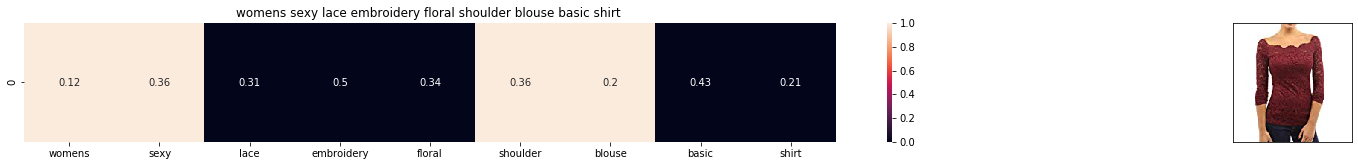

ASIN : B0755CJP2F
BRAND : Rbwinner
Eucliden distance from the given image : 1.233316251373058


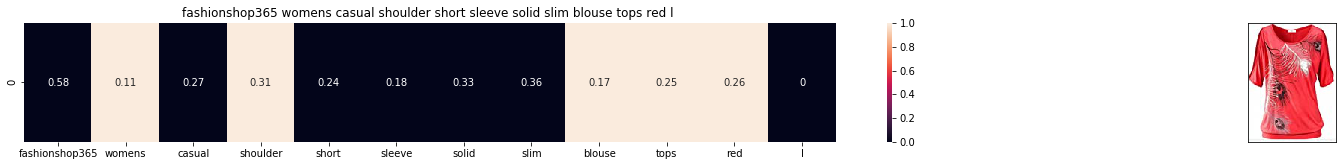

ASIN : B01HTR6KMI
BRAND : FashionShop365
Eucliden distance from the given image : 1.2359090147632337


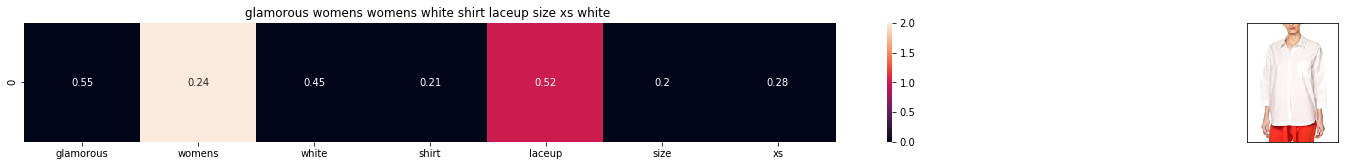

ASIN : B06Y452LTG
BRAND : Glamorous
Eucliden distance from the given image : 1.236033394152962


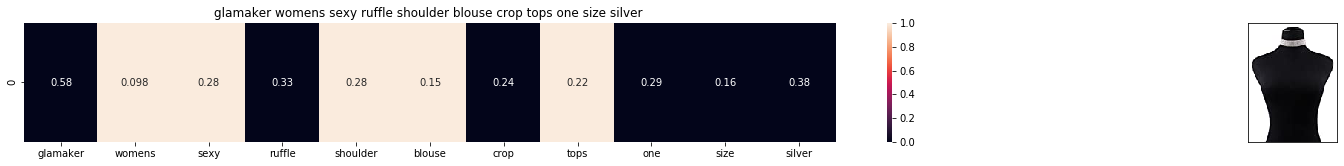

ASIN : B071G88V91
BRAND : Glamaker
Eucliden distance from the given image : 1.2364636877858524


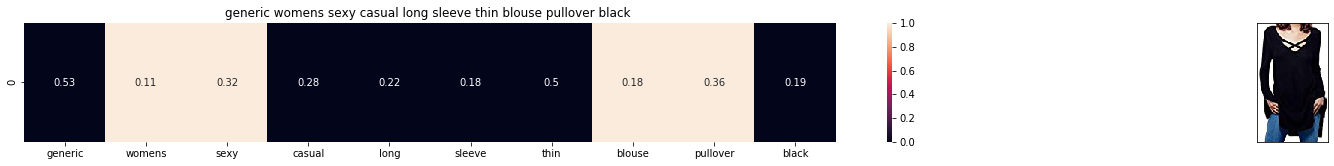

ASIN : B01AFL5WTW
BRAND : Absolutely
Eucliden distance from the given image : 1.2372193356147667


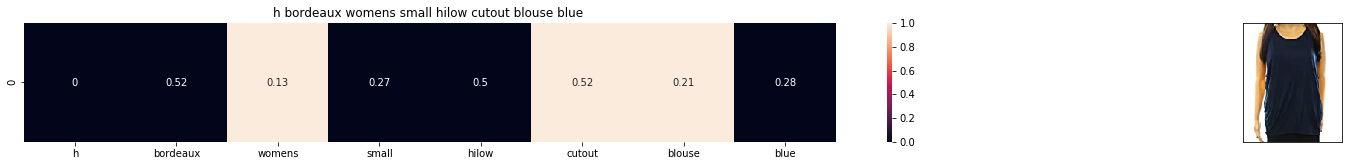

ASIN : B072JGWFX3
BRAND : H By Bordeaux
Eucliden distance from the given image : 1.2380234820355833


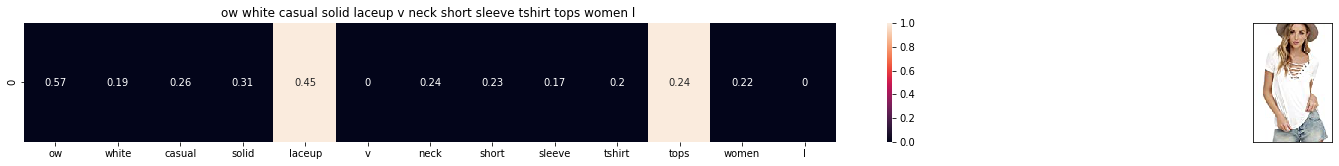

ASIN : B01H59CNMG
BRAND : Our Wings
Eucliden distance from the given image : 1.2385344142482289


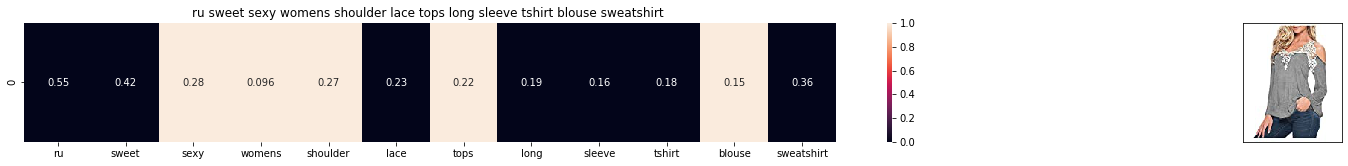

ASIN : B01BG9SVRC
BRAND : Ru Sweet-Clothes
Eucliden distance from the given image : 1.239871526542083


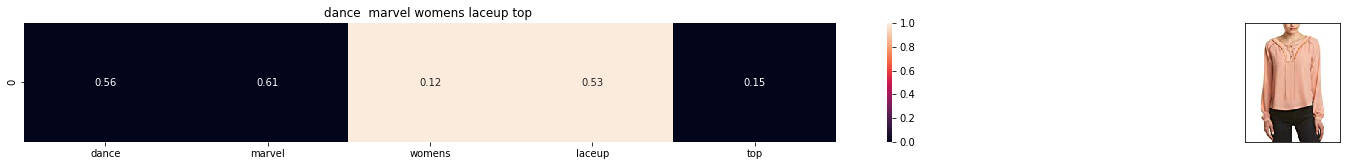

ASIN : B01M292S4C
BRAND : Dance & Marvel
Eucliden distance from the given image : 1.2428650959241447


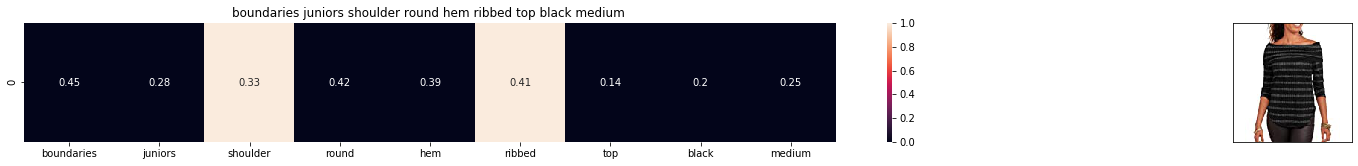

ASIN : B071LGL2Y6
BRAND : No Boundaries
Eucliden distance from the given image : 1.244082762454895


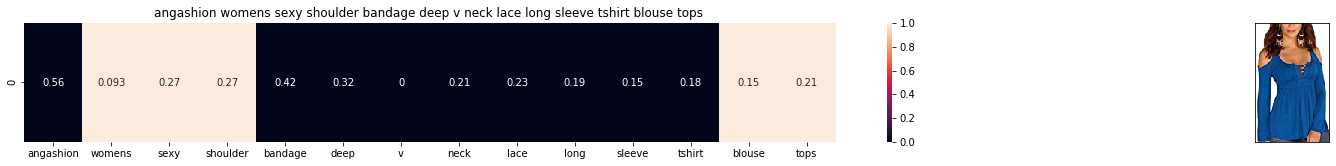

ASIN : B01MYLZLZ8
BRAND : Angashion
Eucliden distance from the given image : 1.2445333379515457


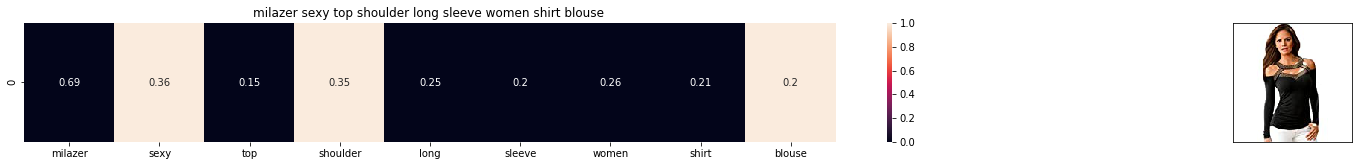

ASIN : B01MXMI7D1
BRAND : Milazer
Eucliden distance from the given image : 1.2448253688133217


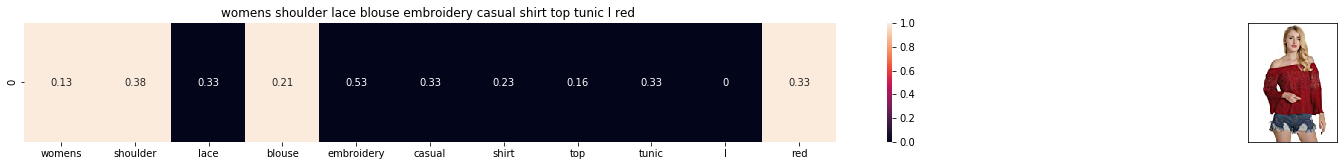

ASIN : B06X9NZ4CC
BRAND : DAYSOFT
Eucliden distance from the given image : 1.2454419048911558


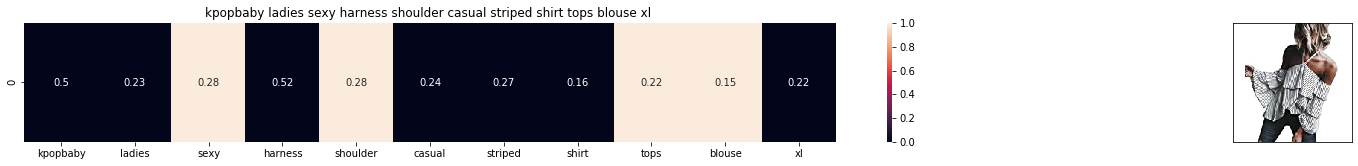

ASIN : B074KM7GP1
BRAND : KpopBaby
Eucliden distance from the given image : 1.24560404993142


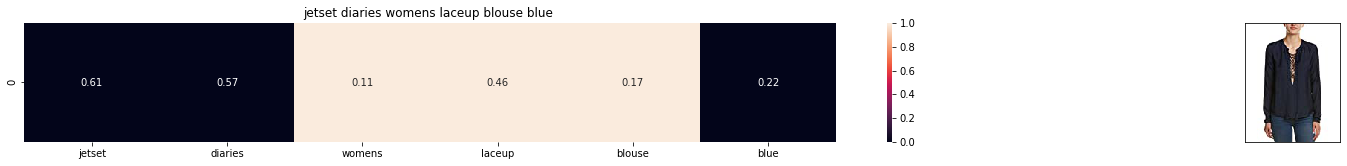

ASIN : B071GTZ236
BRAND : The Jetset Diaries
Eucliden distance from the given image : 1.2475095310886086


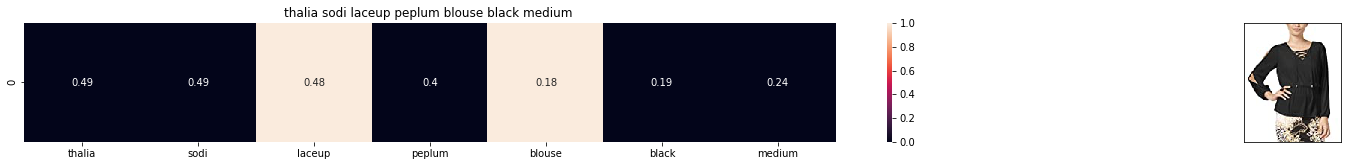

ASIN : B0753JHVH4
BRAND : Thalia
Eucliden distance from the given image : 1.2479546967967234


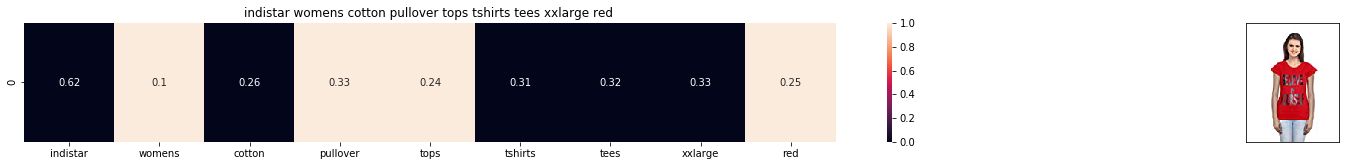

ASIN : B01DBMWKAQ
BRAND : Indistar
Eucliden distance from the given image : 1.248213830182072


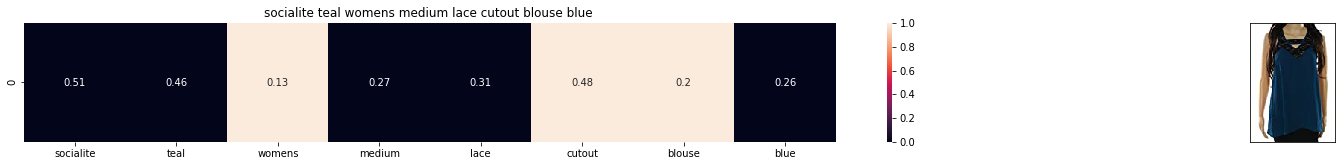

ASIN : B01MZ0KLSX
BRAND : Socialite
Eucliden distance from the given image : 1.2497693195210486


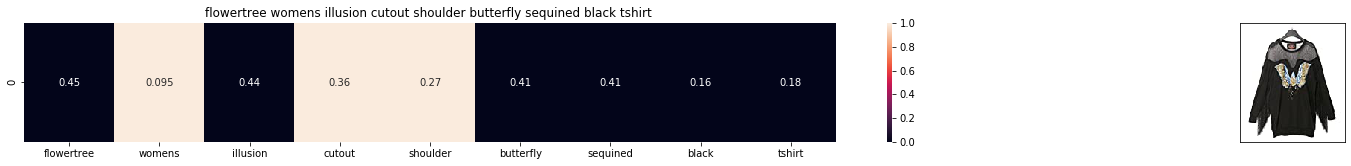

ASIN : B00XKL6DDO
BRAND : flowertree
Eucliden distance from the given image : 1.251642441481158


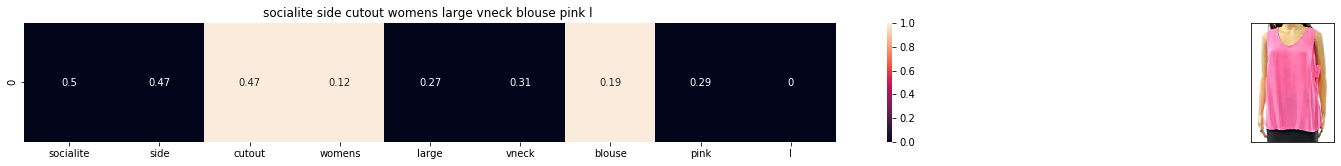

ASIN : B072J2MBXX
BRAND : Socialite
Eucliden distance from the given image : 1.2530882410818127


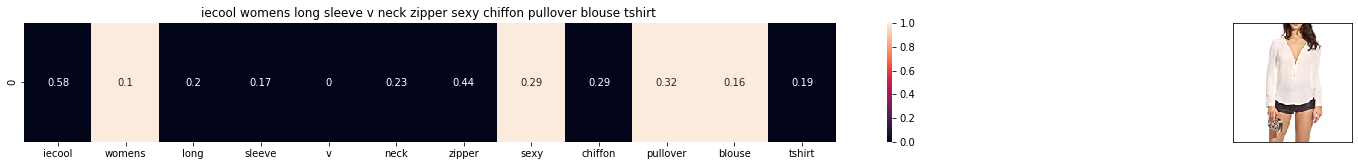

ASIN : B00WRAMS6A
BRAND : iecool
Eucliden distance from the given image : 1.2537973039043953


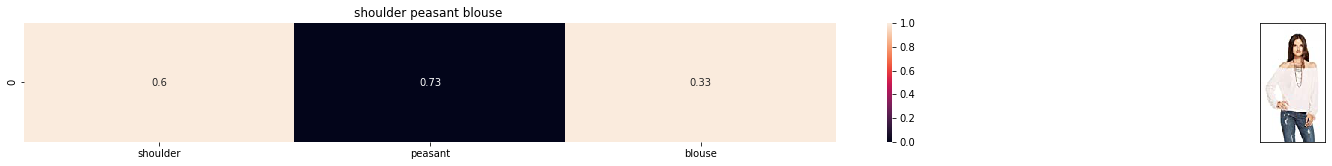

ASIN : B01E1QD5PK
BRAND : CHASER
Eucliden distance from the given image : 1.25482564432423


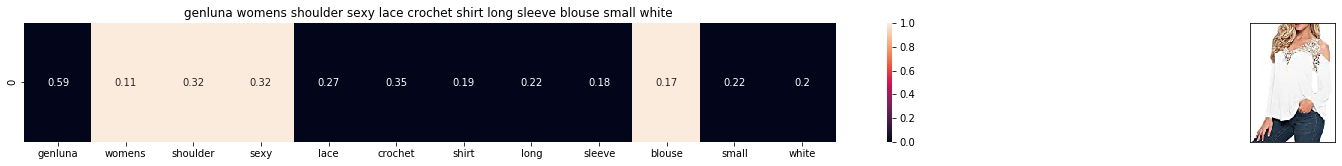

ASIN : B01LZRBG03
BRAND : Genluna
Eucliden distance from the given image : 1.2549380594243071


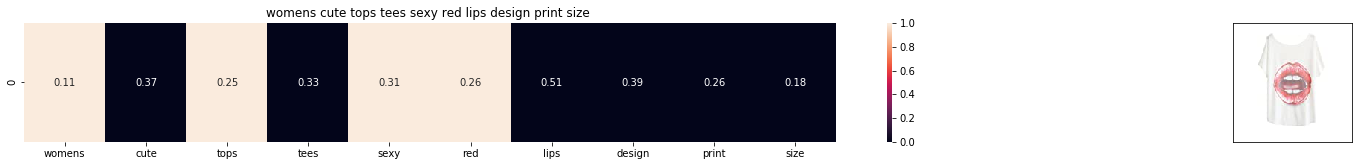

ASIN : B019TKMLM6
BRAND : Namnoi Cute Tee Top
Eucliden distance from the given image : 1.255744186272523


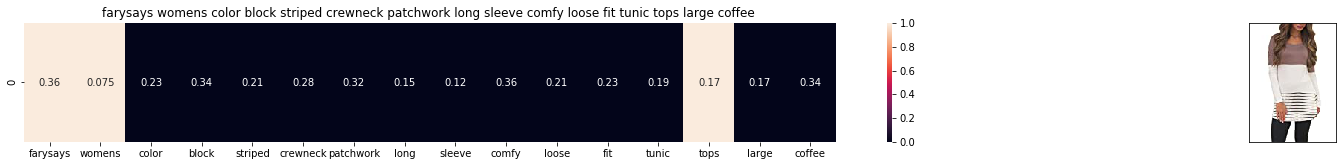

ASIN : B01N1Z7JB7
BRAND : FARYSAYS
Eucliden distance from the given image : 1.2559663681958275


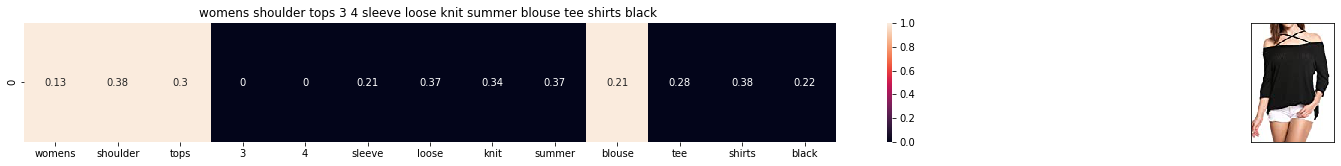

ASIN : B071G2C7Q4
BRAND : JQstar
Eucliden distance from the given image : 1.2561134119303543


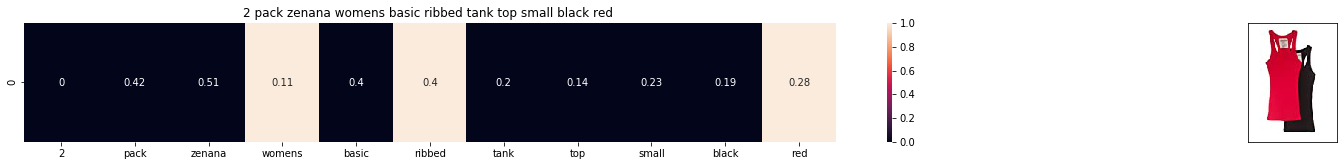

ASIN : B00HDZM2RO
BRAND : Zenana Outfitters
Eucliden distance from the given image : 1.257283770774227


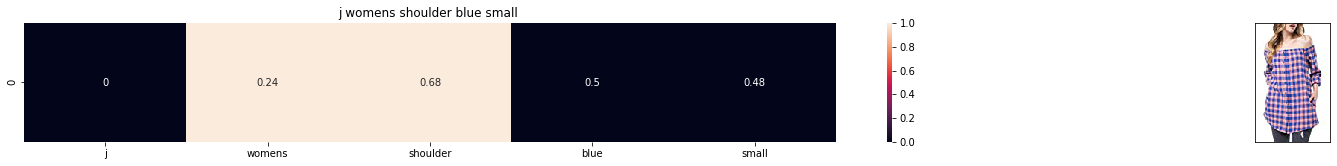

ASIN : B07583CQFT
BRAND : Very J
Eucliden distance from the given image : 1.257437967119585


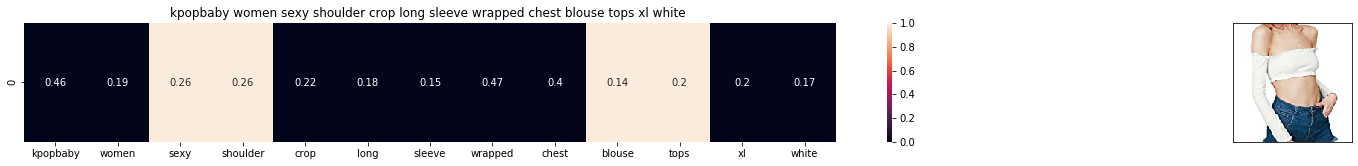

ASIN : B074K7G9X3
BRAND : KpopBaby
Eucliden distance from the given image : 1.2584254423248395


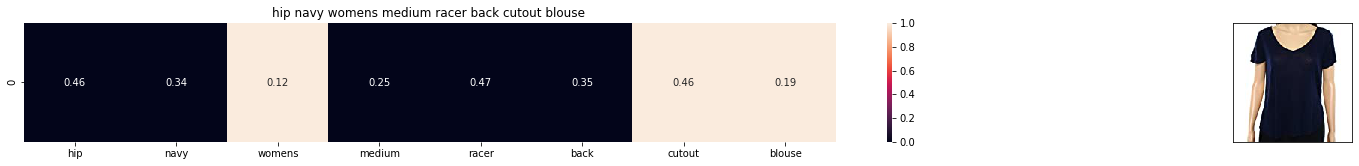

ASIN : B074PBR74S
BRAND : Hip
Eucliden distance from the given image : 1.2584307988132761


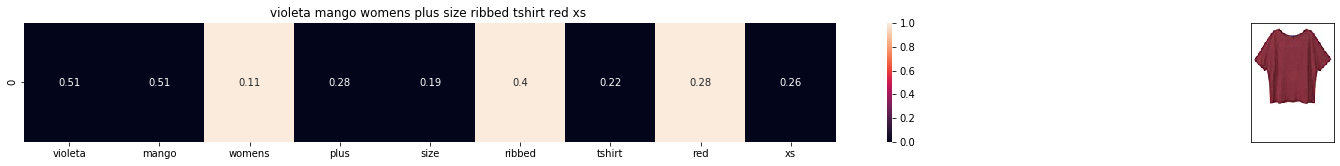

ASIN : B07351H7R6
BRAND : Violeta by MANGO
Eucliden distance from the given image : 1.2585096701557943


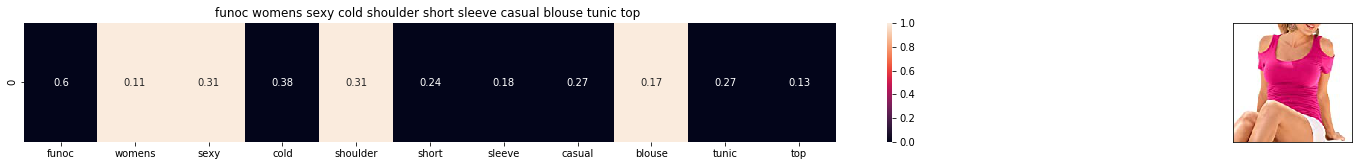

ASIN : B01KHJU4Q8
BRAND : FUNOC
Eucliden distance from the given image : 1.2586083179379939


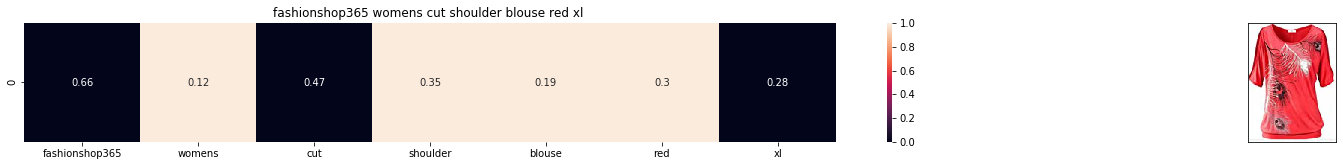

ASIN : B01HTR6LPO
BRAND : FashionShop365
Eucliden distance from the given image : 1.2591389897026342


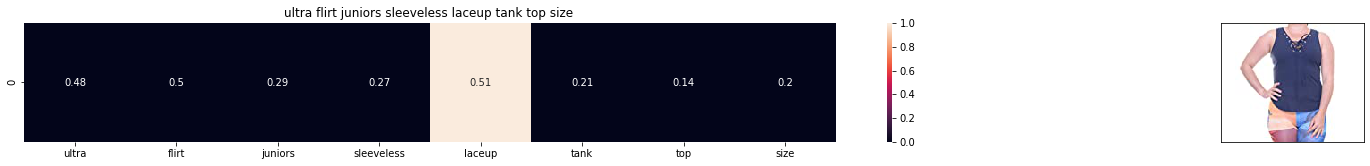

ASIN : B07256JWT6
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.2592606874970949


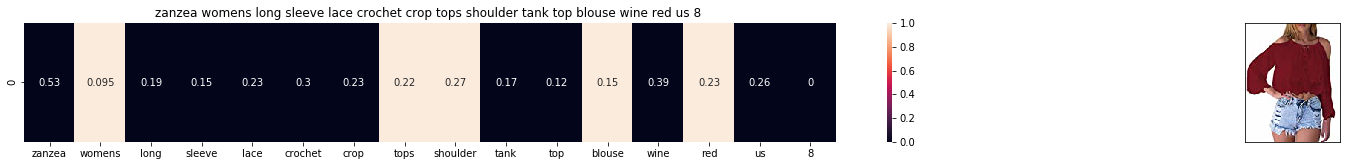

ASIN : B06VVNN7HJ
BRAND : StyleDome
Eucliden distance from the given image : 1.2603847624681517


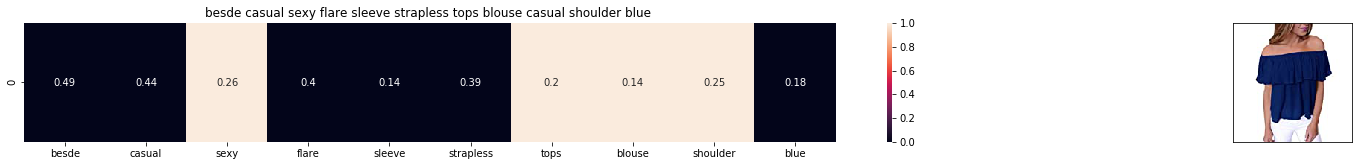

ASIN : B074FXZFW4
BRAND : Besde
Eucliden distance from the given image : 1.261024571004697


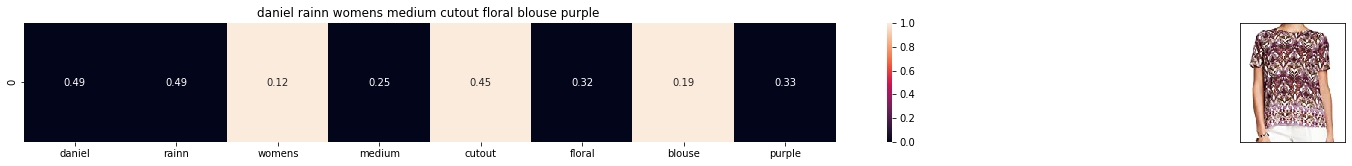

ASIN : B01LZ5Y785
BRAND : Daniel Rainn
Eucliden distance from the given image : 1.2616382034604756


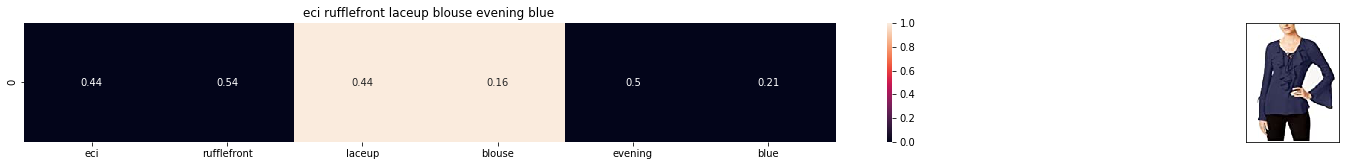

ASIN : B072QBT6BK
BRAND : ECI
Eucliden distance from the given image : 1.261868001667457


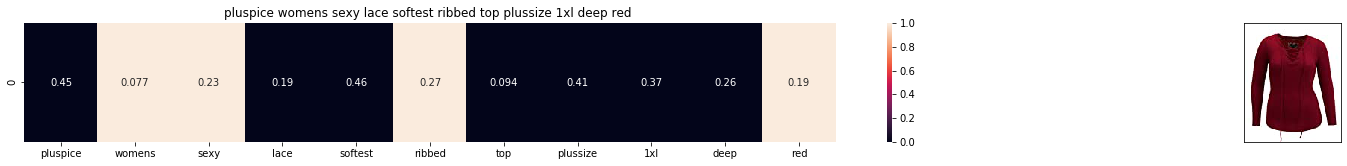

ASIN : B01N0OF80D
BRAND : PLUSPICE
Eucliden distance from the given image : 1.2619961238400945


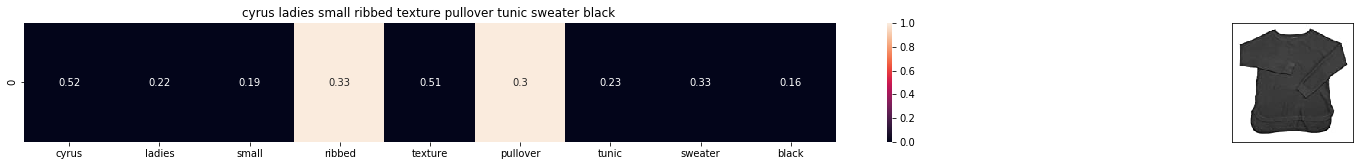

ASIN : B06XN6R331
BRAND : Cyrus
Eucliden distance from the given image : 1.2622472119948407


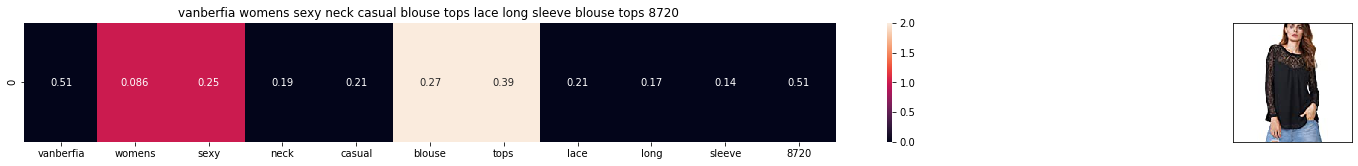

ASIN : B01LZGDZZT
BRAND : Vanberfia
Eucliden distance from the given image : 1.2626436520114694


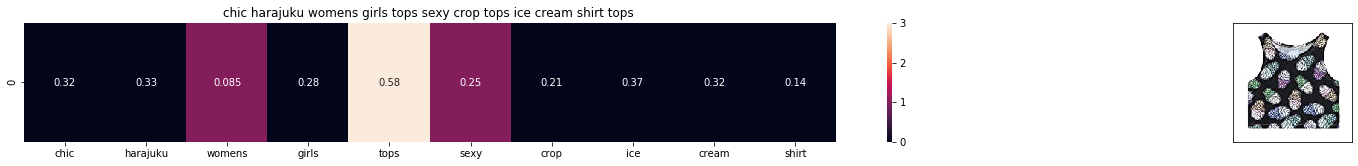

ASIN : B011OU4Q2W
BRAND : Chiclook Cool
Eucliden distance from the given image : 1.2633364693712403


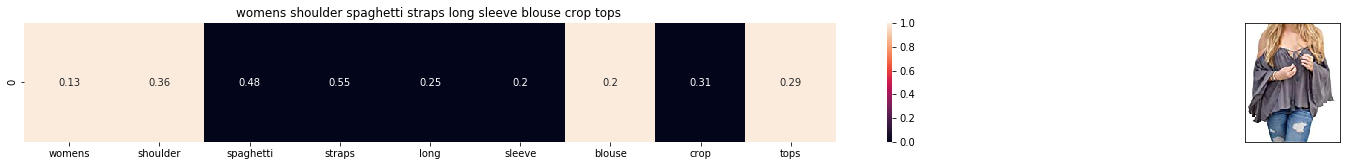

ASIN : B01G3KYY98
BRAND : ouwoow
Eucliden distance from the given image : 1.2633898939360146


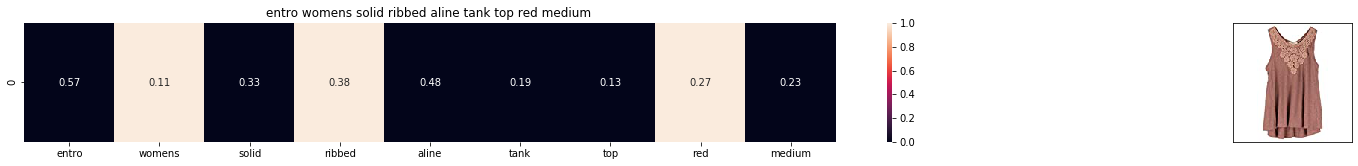

ASIN : B01DCLKXW8
BRAND : Entro
Eucliden distance from the given image : 1.2644150155838407


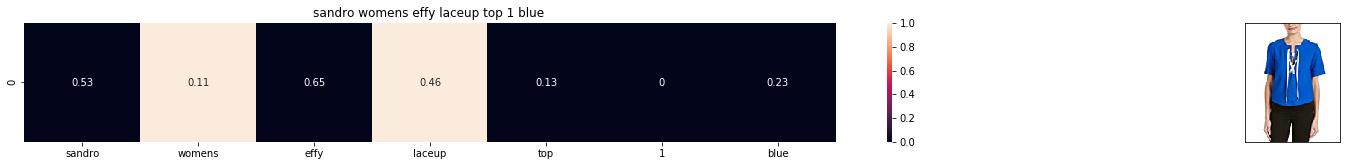

ASIN : B06XNN62FB
BRAND : Sandro
Eucliden distance from the given image : 1.265083809780263


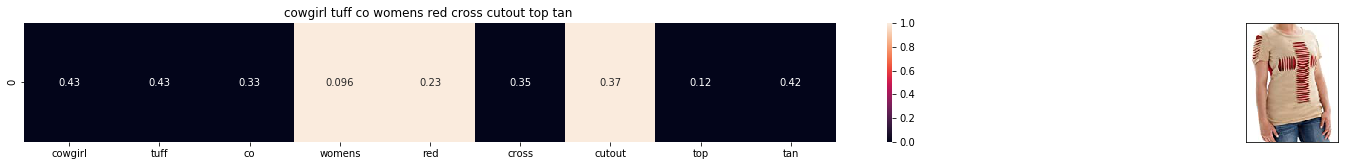

ASIN : B01K6JTRQC
BRAND : Cowgirl Tuff
Eucliden distance from the given image : 1.265167610613084


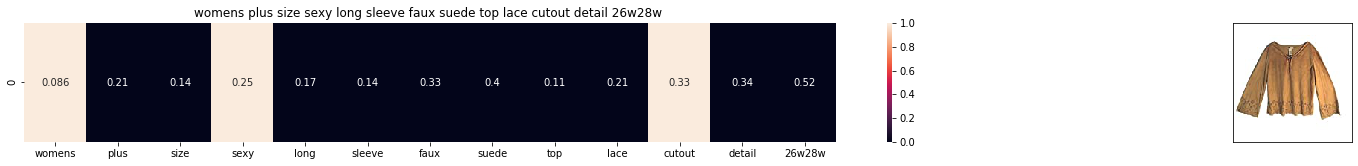

ASIN : B01M1HN897
BRAND : Fifth Degree
Eucliden distance from the given image : 1.2655677578666875


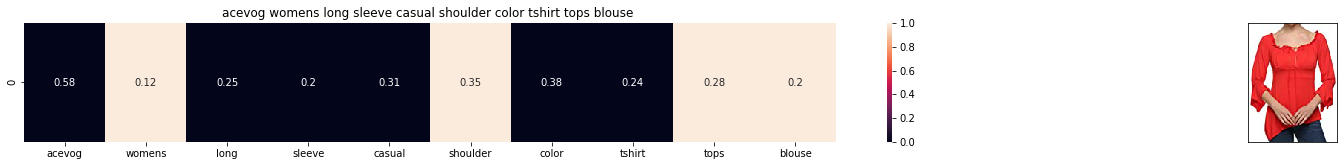

ASIN : B01CE4GI78
BRAND : ACEVOG
Eucliden distance from the given image : 1.2655913874382183


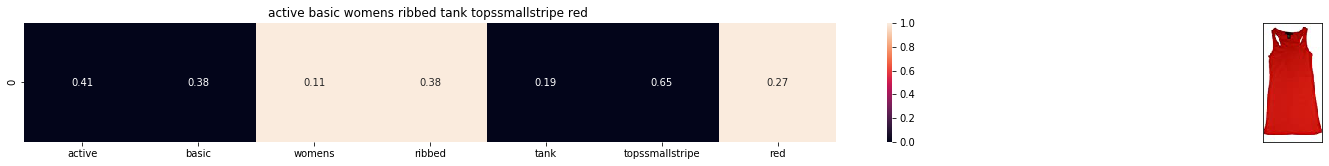

ASIN : B00LB7SRNI
BRAND : Active Products
Eucliden distance from the given image : 1.2658337073622599


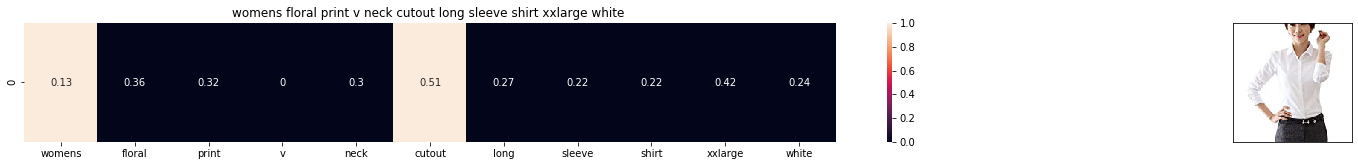

ASIN : B073PVRCW4
BRAND : Arctic Leaf
Eucliden distance from the given image : 1.2661724999326758


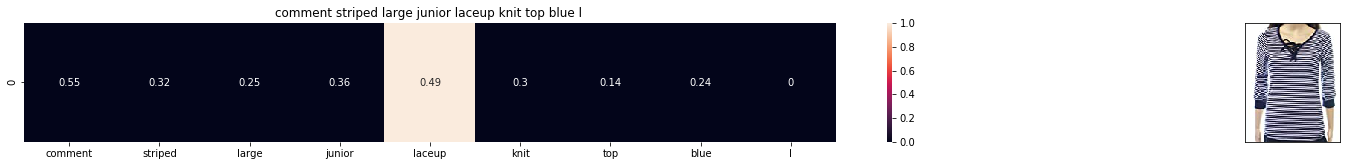

ASIN : B071942WNH
BRAND : No Comment
Eucliden distance from the given image : 1.2662702202365788


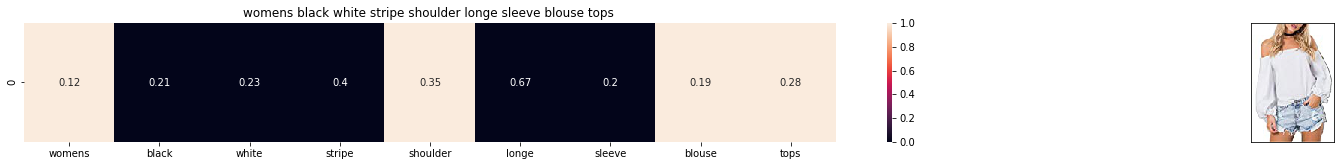

ASIN : B01KO8HUV4
BRAND : ouwoow
Eucliden distance from the given image : 1.2662815784450365


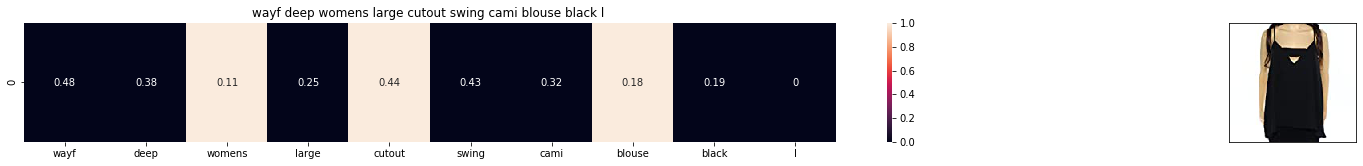

ASIN : B0756LF2WM
BRAND : WAYF
Eucliden distance from the given image : 1.2670533190700735


In [47]:
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(124, 87)
